In [1]:
import os
import warnings
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import gamma, norm, expon
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings("ignore")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Load the dataset
data_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "dataset")
data = pd.read_excel(f"{data_path}/data_transformed.xlsx")
# Drop the unnamed column as it is unnecessary for correlation analysis
data = data.drop(columns=['Unnamed: 0'])

In [3]:
data.head(20)

CO(GT)  PT08.S1(CO)  NMHC(GT)   C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
0      2.6      1360.00       150  11.881723        1045.50      166   
1      2.0      1292.25       112   9.397165         954.75      103   
2      2.2      1402.00        88   8.997817         939.25      131   
3      2.2      1375.50        80   9.228796         948.25      172   
4      1.6      1272.25        51   6.518224         835.50      131   
5      1.2      1197.00        38   4.741012         750.25       89   
6      1.2      1185.00        31   3.624399         689.50       62   
7      1.0      1136.25        31   3.326677         672.00       62   
8      0.9      1094.00        24   2.339416         608.50       45   
9      0.7      1066.00         8   1.133431         512.00       16   
10     0.7      1051.75        16   1.603768         553.25       34   
11     1.1      1144.00        29   3.243618         667.00       98   
12     2.0      1333.25        64   8.013773         899.75      174   
13     2.2      1351.00        87   9.540643         960.25      129   
14     1.7      1233.25        77   6.335782         827.25      112   
15     1.5      1178.75        43   4.971584         762.00       95   
16     1.6      1236.00        61   5.216919         774.25      104   
17     1.9      1285.50        63   7.269933         868.50      146   
18     2.9      1371.00       164  11.539007        1033.50      207   
19     2.2      1310.00        79   8.826223         932.50      184   

    PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)       T         RH  \
0        1056.25      113       1692.00      1267.50  13.600  48.875001   
1        1173.75       92       1558.75       972.25  13.300  47.700000   
2        1140.00      114       1554.50      1074.00  11.900  53.975000   
3        1092.00      122       1583.75      1203.25  11.000  60.000000   
4        1205.00      116       1490.00      1110.00  11.150  59.575001   
5        1336.50       96       1393.00       949.25  11.175  59.175000   
6        1461.75       77       1332.75       732.50  11.325  56.775000   
7        1453.25       76       1332.75       729.50  10.675  60.000000   
8        1579.00       60       1276.00       619.50  10.650  59.674999   
9        1918.00       28       1182.00       421.75  11.000  56.175000   
10       1738.25       48       1221.25       471.50  10.450  58.125000   
11       1489.75       82       1339.00       729.75  10.200  59.599999   
12       1136.00      112       1517.00      1101.50  10.750  57.425000   
13       1079.00      101       1582.75      1027.75  10.500  60.599998   
14       1218.00       98       1445.75       859.75  10.800  58.350000   
15       1327.50       92       1361.75       670.50  10.500  57.925000   
16       1301.25       95       1401.25       664.00   9.525  66.774999   
17       1162.25      112       1536.75       799.00   8.300  76.425001   
18        983.25      128       1730.25      1036.50   8.000  81.150000   
19       1081.75      126       1646.50       946.25   8.325  79.799999   

          AH  
0   0.757754  
1   0.725487  
2   0.750239  
3   0.786713  
4   0.788794  
5   0.784772  
6   0.760312  
7   0.770238  
8   0.764819  
9   0.736560  
10  0.735295  
11  0.741736  
12  0.740795  
13  0.769111  
14  0.755183  
15  0.735161  
16  0.795054  
17  0.839268  
18  0.873589  
19  0.877784

In [4]:
data.columns

Index(['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
       'T', 'RH', 'AH'],
      dtype='object')

In [5]:
# initialising min max scaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
scaled_data = pd.DataFrame(scaled_data, columns=data.columns)

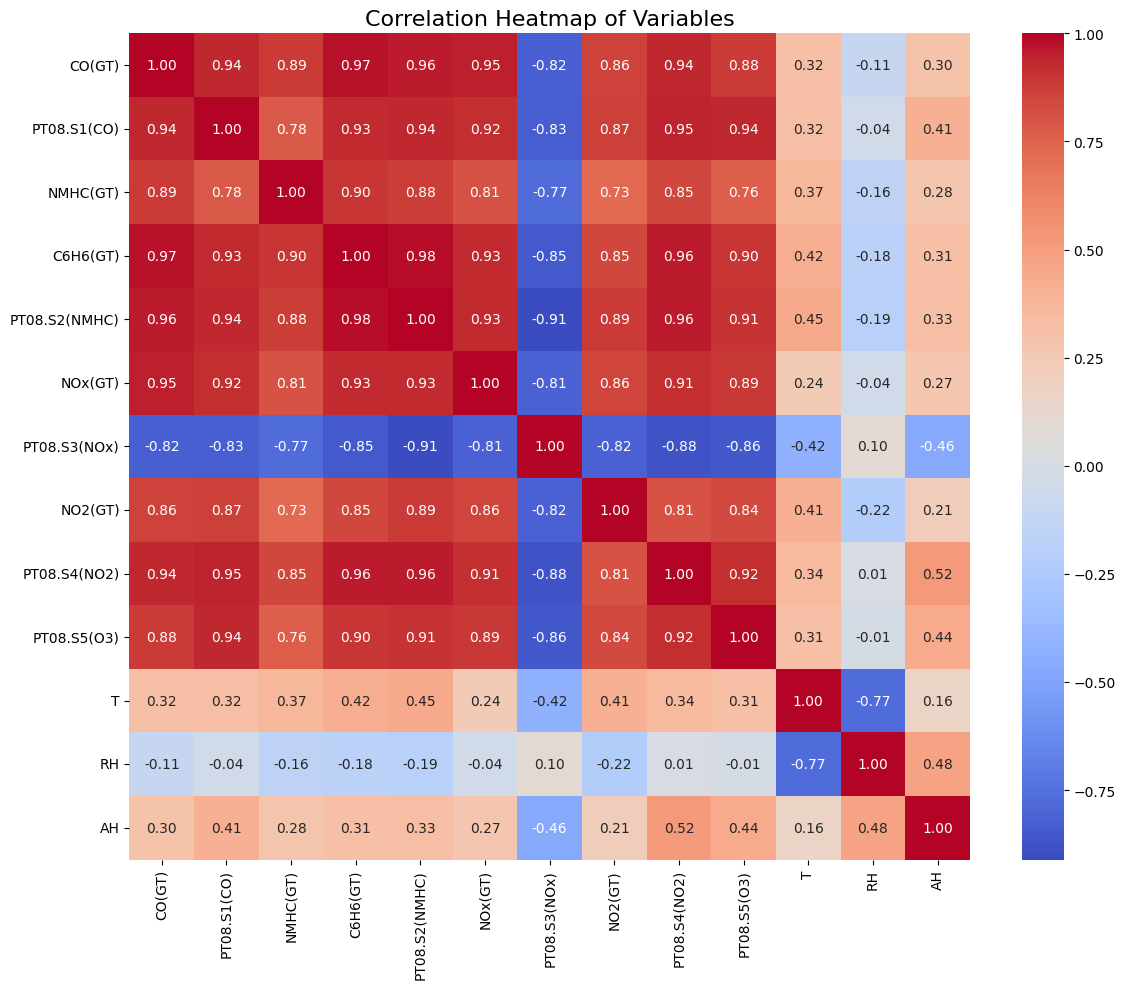

In [6]:
# Calculate the correlation matrix
correlation_matrix = scaled_data.corr()#data.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Variables", fontsize=16)
plt.tight_layout()
plt.savefig("correlation_matrix_after_transformation.png")
plt.show()


Gamma Model

Gamma Model: Prior Check

In [7]:
# Define the target and predictor variables
target_variable = 'C6H6(GT)'
predictor_variables = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 
                    'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

# Subset the data to include only the target and predictor variablesa
# data = data[[target_variable] + predictor_variables].dropna()
scaled_data = scaled_data[[target_variable] + predictor_variables].dropna()

# Prepare predictors and target
X = scaled_data[predictor_variables]
y = scaled_data[target_variable]

# Ensure the target variable contains only positive values
if (y <= 0).any():
    print("Target variable contains non-positive values. Adjusting...")
    y += 0.001  # Add a small constant to ensure positivity

# Perform prior predictive checks
with pm.Model() as gamma_model_prior:
    # Priors for the coefficients
    beta = pm.Normal("beta", mu=0, sigma=10, shape=X.shape[1])
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    
    # Linear predictor
    mu = pm.math.exp(pm.math.dot(X.values, beta) + intercept)
    alpha = pm.HalfCauchy("alpha", beta=2)  # Shape parameter
    
    # Likelihood (without observed data for prior predictive checks)
    target = pm.Gamma("target", alpha=alpha, beta=alpha / mu)
    
    # Sample from the prior predictive distribution
    prior_predictive = pm.sample_prior_predictive()


Target variable contains non-positive values. Adjusting...


Sampling: [alpha, beta, intercept, target]


In [8]:
prior_predictive

Inference data with groups:
	> prior

In [9]:
prior_gamma_beta_shape = prior_predictive["prior"]["beta"].shape
prior_gamma_beta_shape

(1, 500, 12)

In [10]:
prior_gamma_beta_values = prior_predictive["prior"]["beta"].values.reshape(prior_gamma_beta_shape[1], prior_gamma_beta_shape[2])
prior_gamma_beta_values.shape

(500, 12)

In [11]:
prior_gamma_beta_values.shape

(500, 12)

In [12]:
prior_gamma_intercept = prior_predictive["prior"]["intercept"].values.flatten()
type(prior_gamma_intercept)

numpy.ndarray

In [13]:
prior_gamma_alpha = prior_predictive["prior"]["alpha"].values.flatten()
type(prior_gamma_alpha)

numpy.ndarray

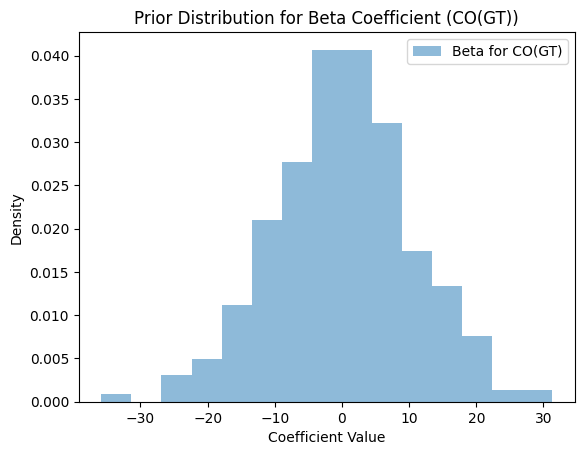

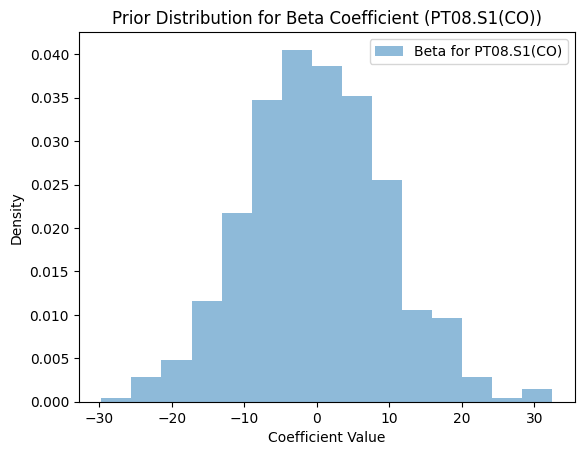

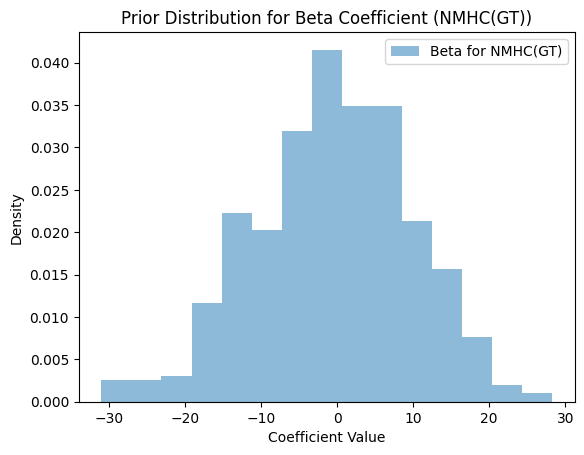

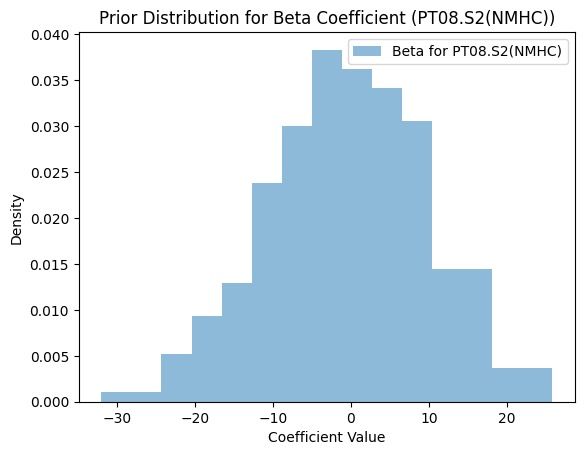

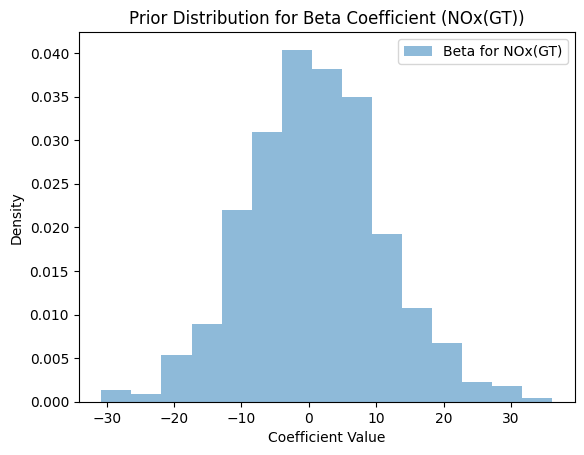

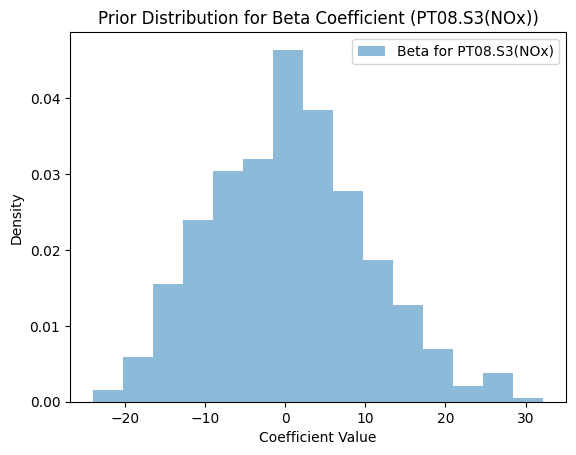

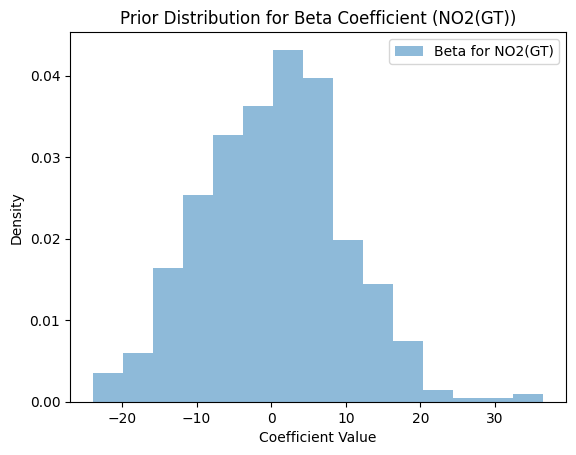

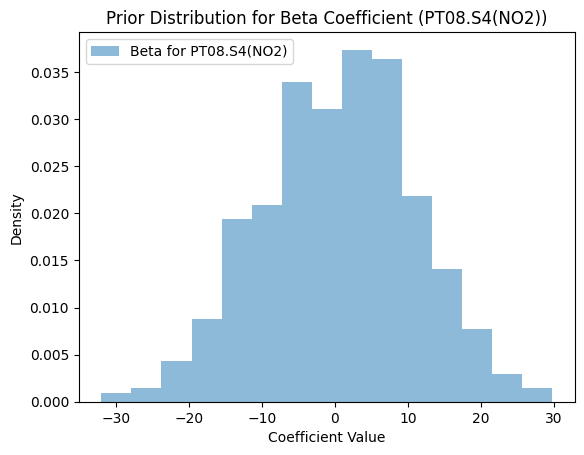

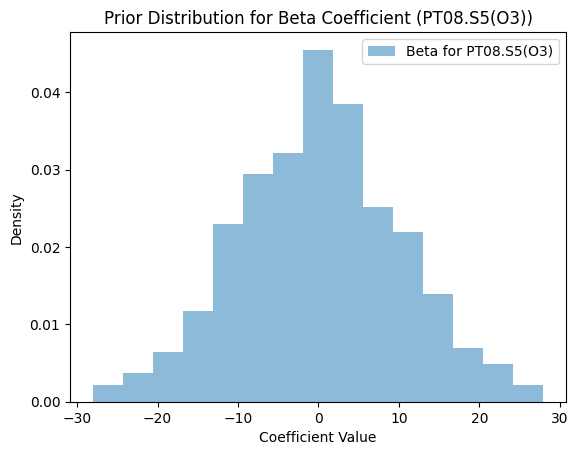

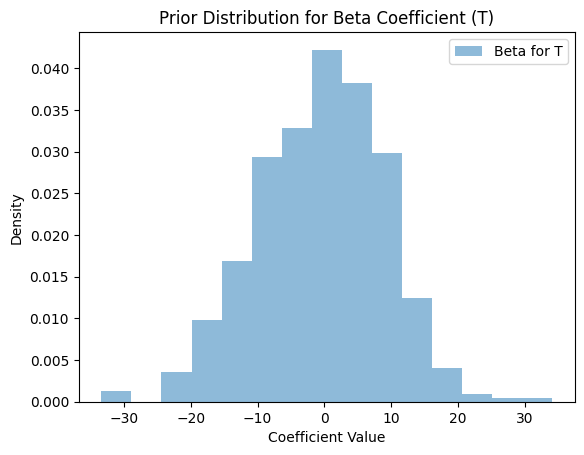

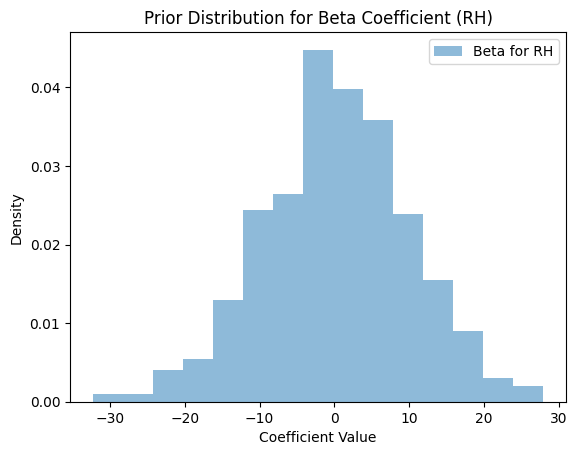

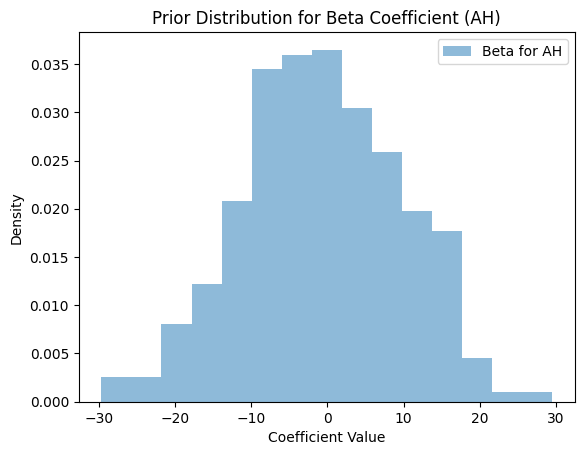

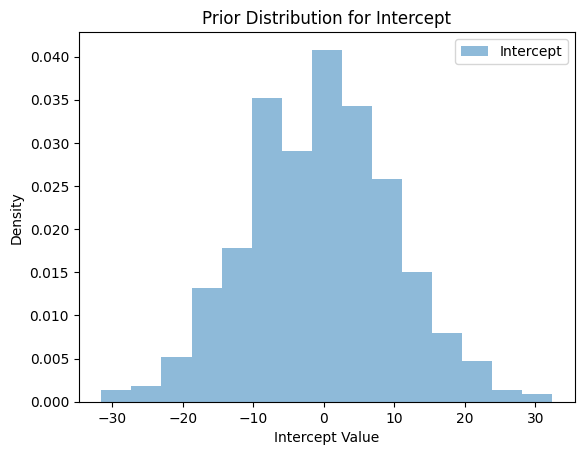

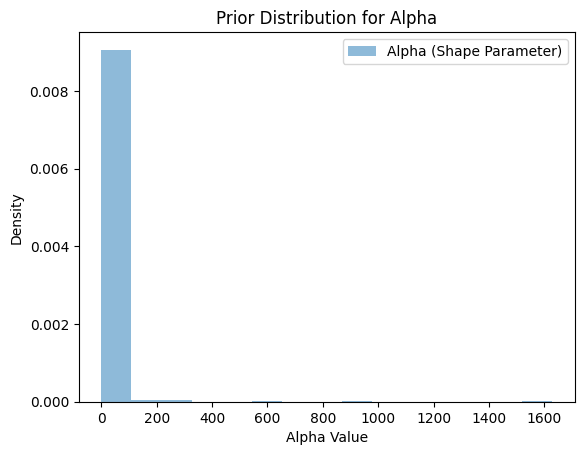

In [14]:
# Plot priors for coefficients (beta)
for i, predictor in enumerate(predictor_variables):
    # prior_predictive["prior"]["beta"]
    plt.hist(prior_gamma_beta_values[:, i], bins=15, density=True, alpha=0.5, label=f"Beta for {predictor}")
    plt.title(f"Prior Distribution for Beta Coefficient ({predictor})")
    plt.xlabel("Coefficient Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

# Plot prior for intercept
plt.hist(prior_gamma_intercept, bins=15, density=True, alpha=0.5, label="Intercept")
plt.title("Prior Distribution for Intercept")
plt.xlabel("Intercept Value")
plt.ylabel("Density")
plt.legend()
plt.show()

# Plot prior for alpha
plt.hist(prior_gamma_alpha, bins=15, density=True, alpha=0.5, label="Alpha (Shape Parameter)")
plt.title("Prior Distribution for Alpha")
plt.xlabel("Alpha Value")
plt.ylabel("Density")
plt.legend()
plt.show()

Gamma Model: Posterior Check

In [15]:
# Define the target and predictor variables
target_variable = 'C6H6(GT)'
predictor_variables = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 
                    'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

# Subset the data to include only the target and predictor variablesa
# data = data[[target_variable] + predictor_variables].dropna()
scaled_data = scaled_data[[target_variable] + predictor_variables].dropna()

# Prepare predictors and target
X = scaled_data[predictor_variables]
y = scaled_data[target_variable]

# Ensure the target variable contains only positive values
if (y <= 0).any():
    print("Target variable contains non-positive values. Adjusting...")
    y += 0.001  # Add a small constant to ensure positivity

# Define the Bayesian Gamma Regression Model
with pm.Model() as gamma_model:
    # Priors for the coefficients
    beta = pm.Normal("beta", mu=0, sigma=10, shape=X.shape[1])
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    
    # Linear predictor
    mu = pm.math.exp(pm.math.dot(X.values, beta) + intercept)
    alpha = pm.HalfCauchy("alpha", beta=2)  # Shape parameter
    
    # Likelihood
    target = pm.Gamma("target", alpha=alpha, beta=alpha / mu, observed=y.values)
    
    # Initialize model with a custom start point
    initial_point = gamma_model.initial_point()
    initial_point["alpha"] = 1.0  # Positive initial value for alpha
    initial_point["beta"] = np.zeros(X.shape[1])  # Start with all coefficients at 0
    initial_point["intercept"] = np.log(np.mean(y))  # Approximate initial intercept
    
    # Sampling
    idata = pm.sample(500, tune=500, init="adapt_diag", start=initial_point)#, return_inferencedata=True

# Summarize the posterior
summary = idata.posterior#.to_dataframe()
# summary.head()


Initializing NUTS using adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [beta, intercept, alpha]


Output()

Sampling 3 chains for 500 tune and 500 draw iterations (1_500 + 1_500 draws total) took 43 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


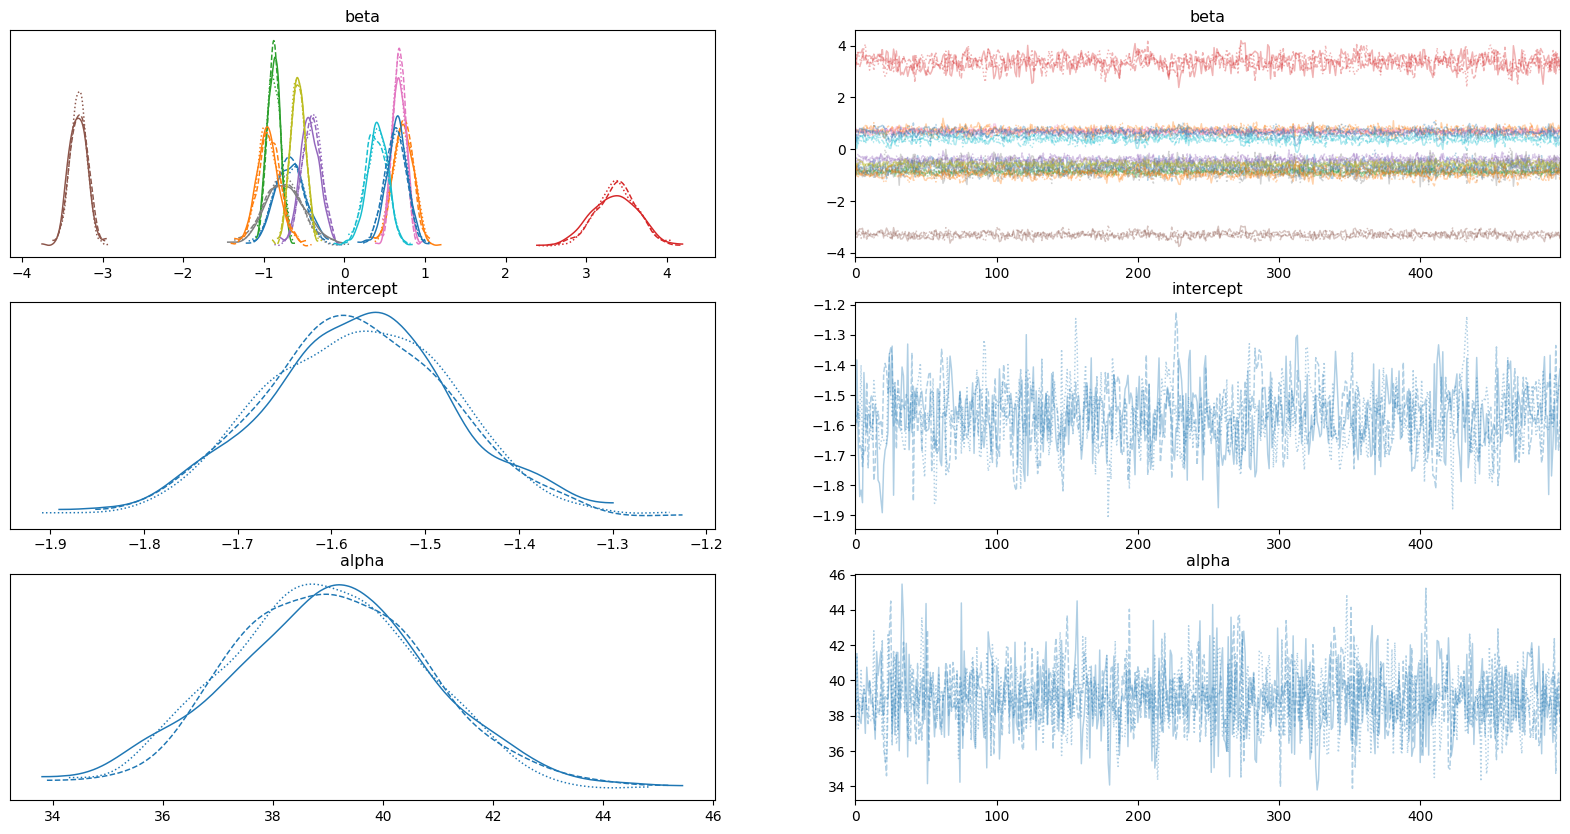

In [16]:
# Save and display posterior diagnostics
# posterior_summary = az.summary(summary)
az.plot_trace(summary, figsize=(20, 10), compact=True) #, var_names=scaled_data.columns
# plt.savefig("traceplot_beta_intercept_alpha.png")
plt.show()

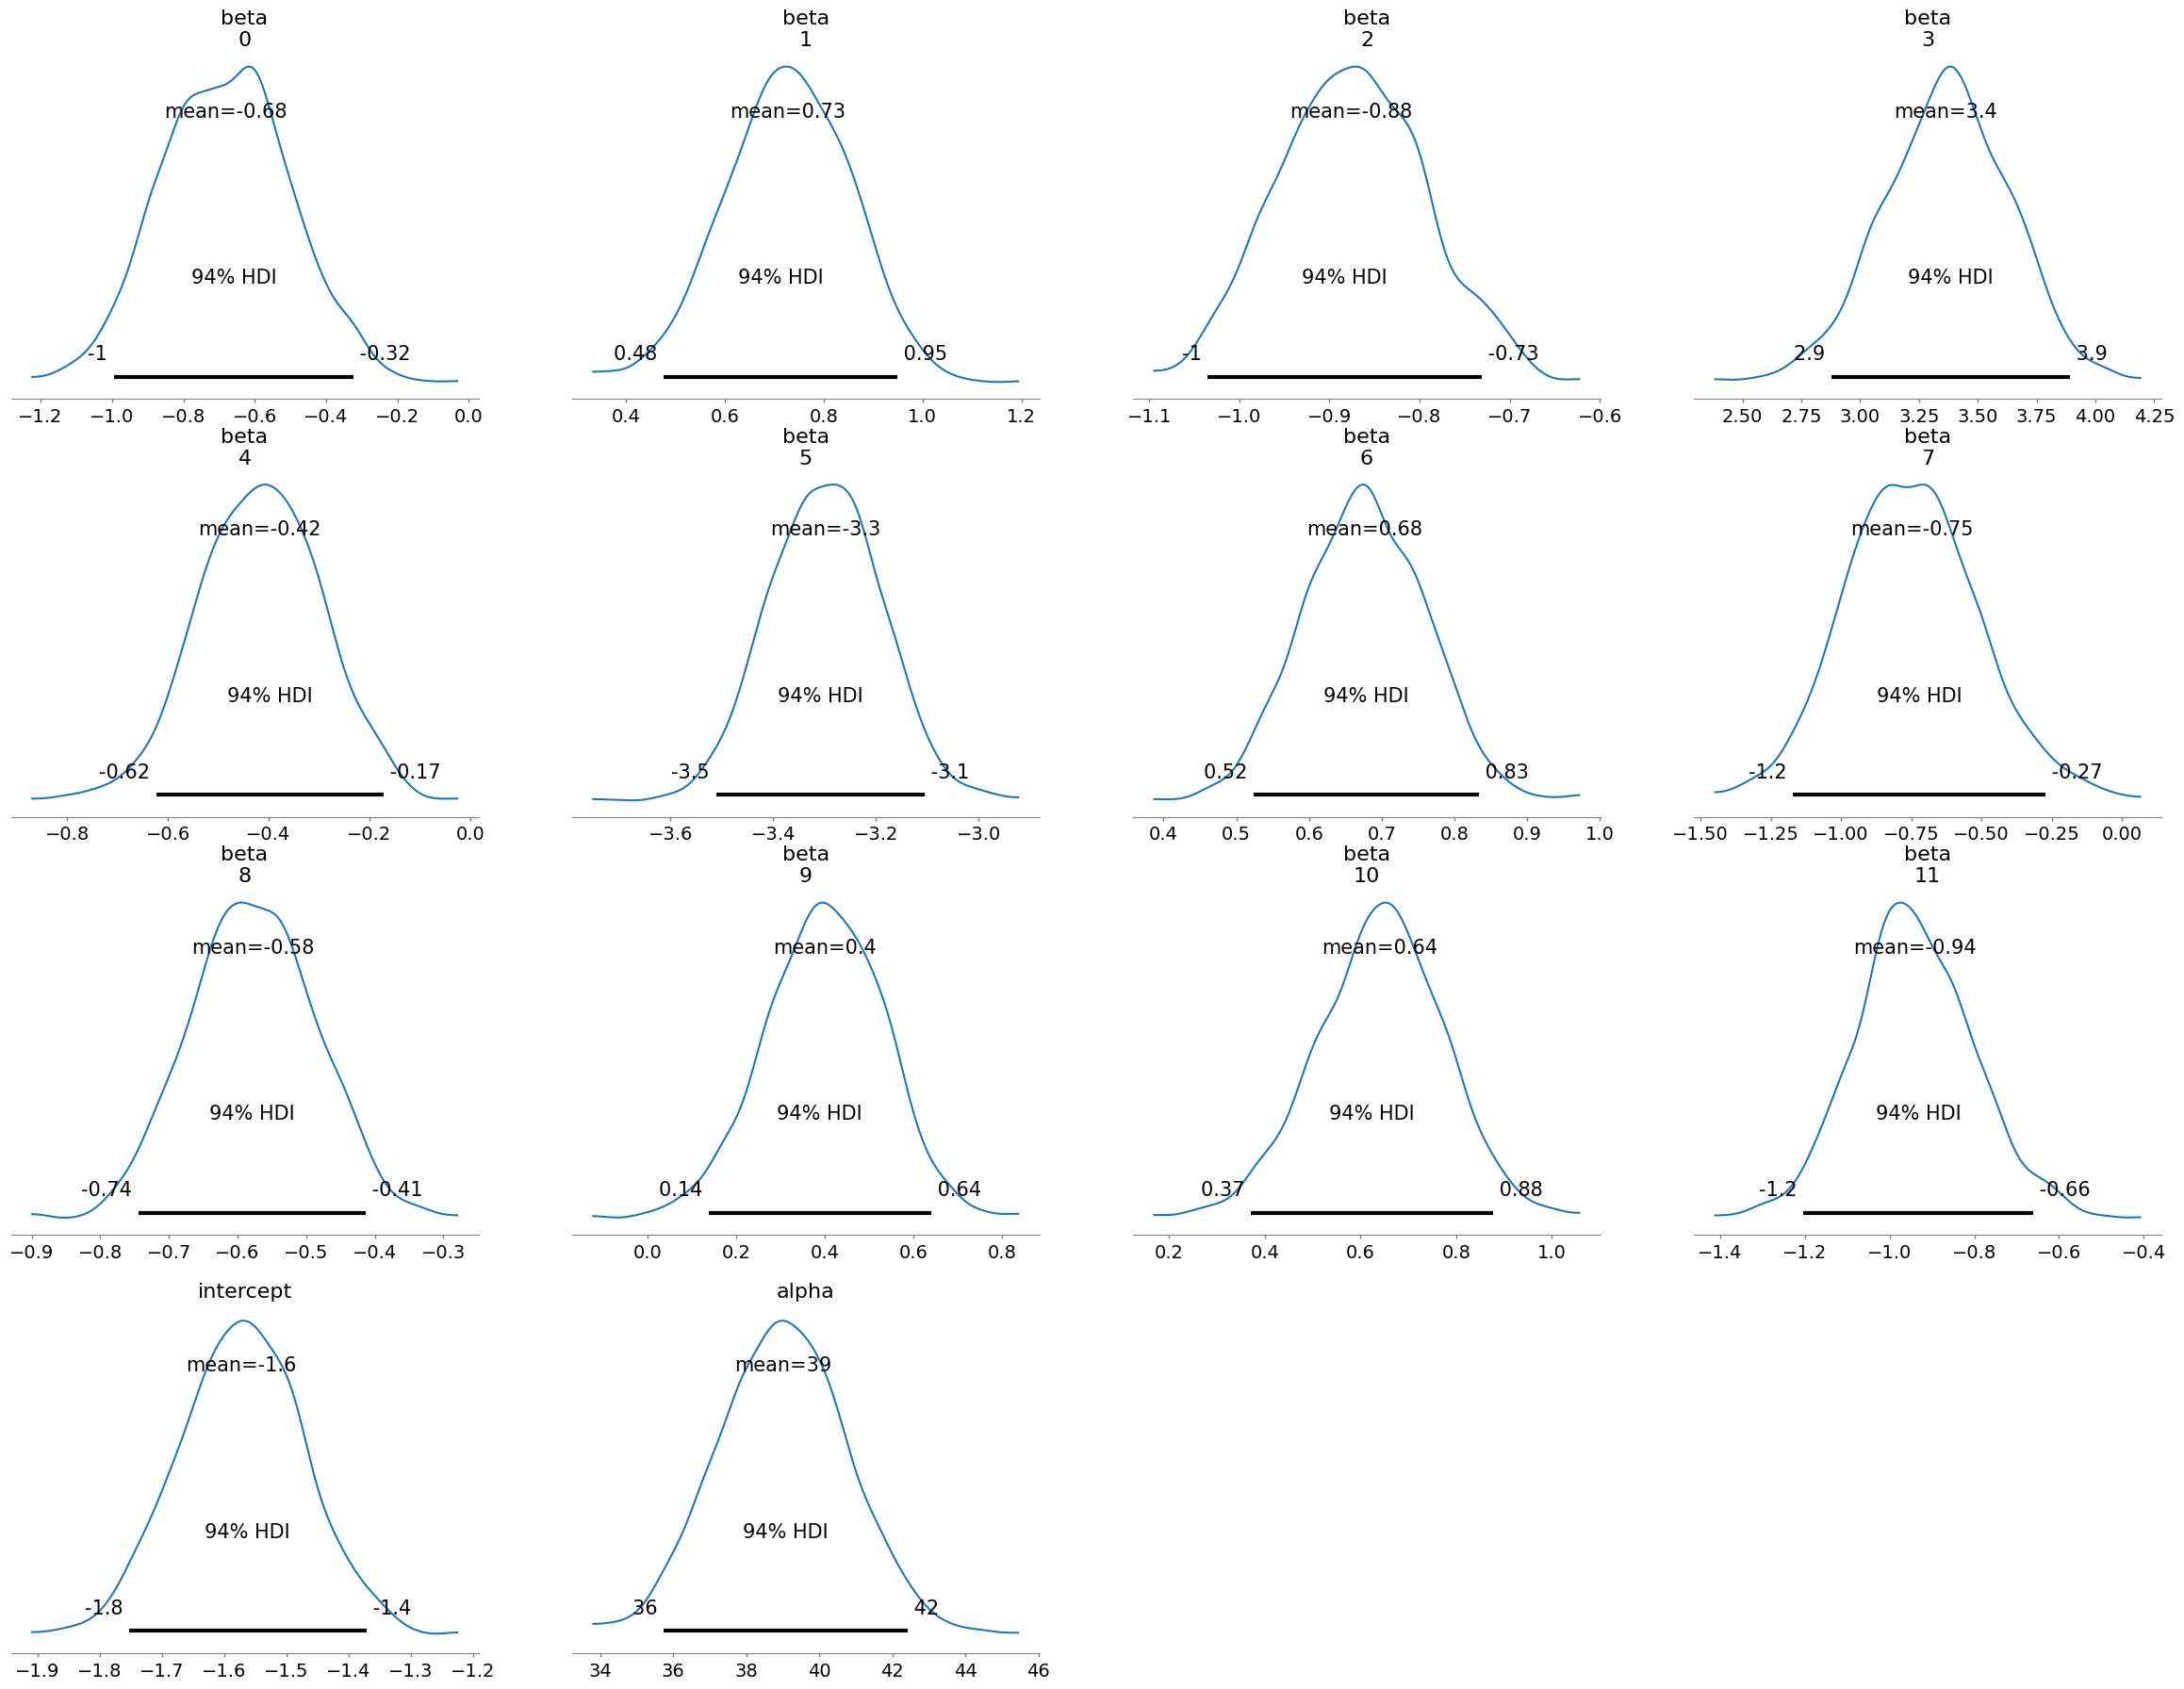

In [17]:
az.plot_posterior(summary)
# plt.savefig("posterior_beta_intercept_alpha.png")
plt.show()

# Display the posterior summary
# posterior_summary.to_csv('/mnt/data/posterior_summary.csv')
# posterior_summary

In [18]:
# Extract posterior samples for beta
gamma_beta_posterior = idata.posterior["beta"]
print(gamma_beta_posterior)

<xarray.DataArray 'beta' (chain: 3, draw: 500, beta_dim_0: 12)> Size: 144kB
array([[[-0.75822132,  0.63631034, -0.81820603, ...,  0.46179896,
          0.69508898, -1.03283779],
        [-0.65306642,  0.72902715, -0.96340989, ...,  0.02257037,
          0.25128899, -0.61261724],
        [-0.56653474,  0.66986793, -0.94457319, ...,  0.34382318,
          0.61724716, -0.86761353],
        ...,
        [-0.92892787,  0.74773798, -0.90249075, ...,  0.42051899,
          0.57585284, -0.96229061],
        [-0.81128743,  0.92251447, -0.69728893, ...,  0.15478342,
          0.4231576 , -0.72162869],
        [-0.81033425,  0.7441944 , -0.91143681, ...,  0.26987647,
          0.46513375, -0.91084325]],

       [[-0.89762115,  0.69286023, -0.73465937, ...,  0.34956136,
          0.53983234, -0.9364571 ],
        [-0.61698649,  0.61913197, -0.93813614, ...,  0.24348927,
          0.54690798, -0.75971149],
        [-0.86298672,  0.66966287, -1.00613785, ...,  0.22079225,
          0.41416349, -0.78

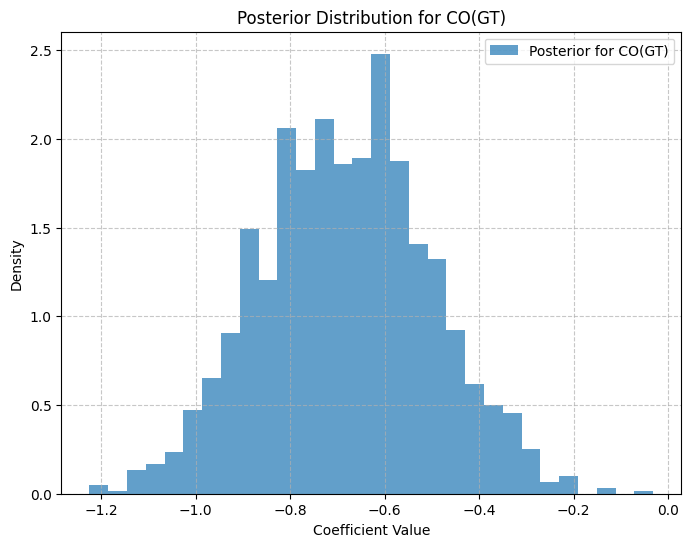

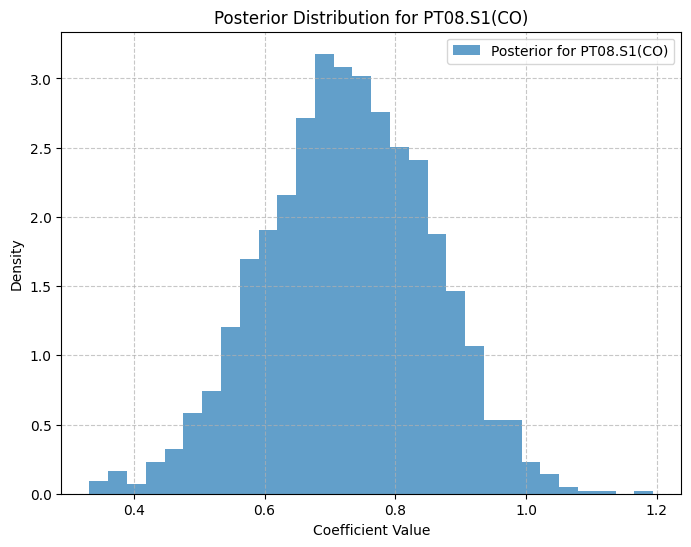

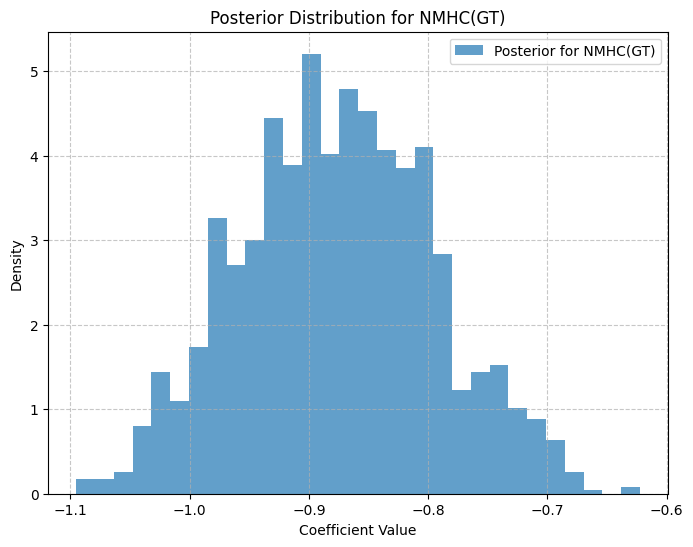

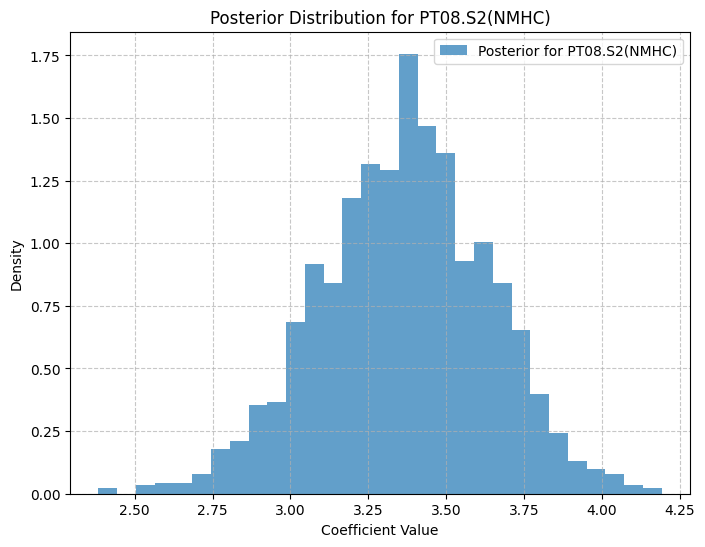

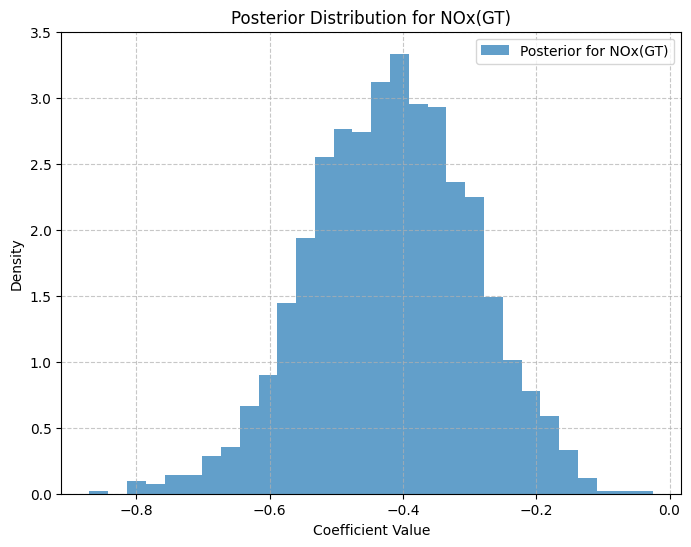

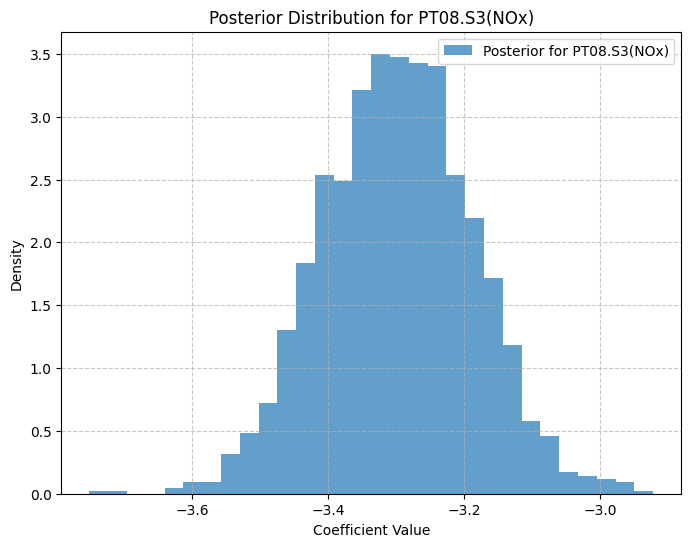

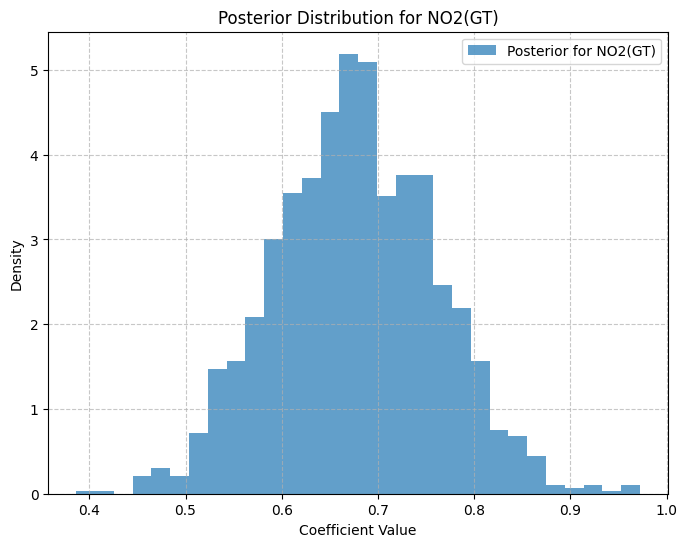

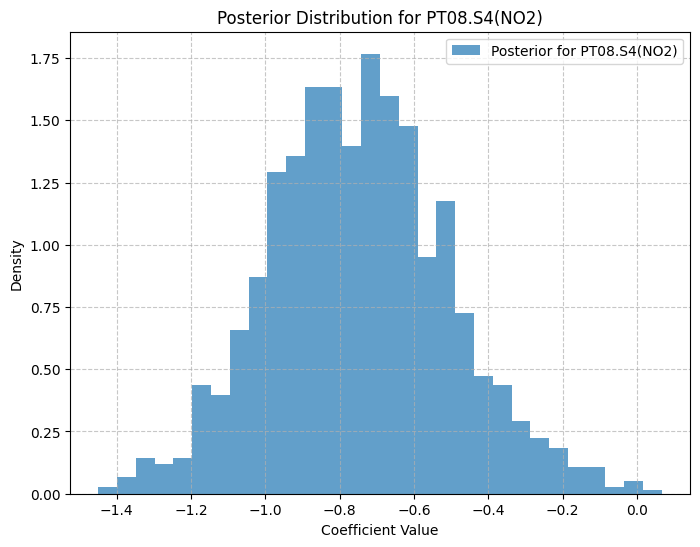

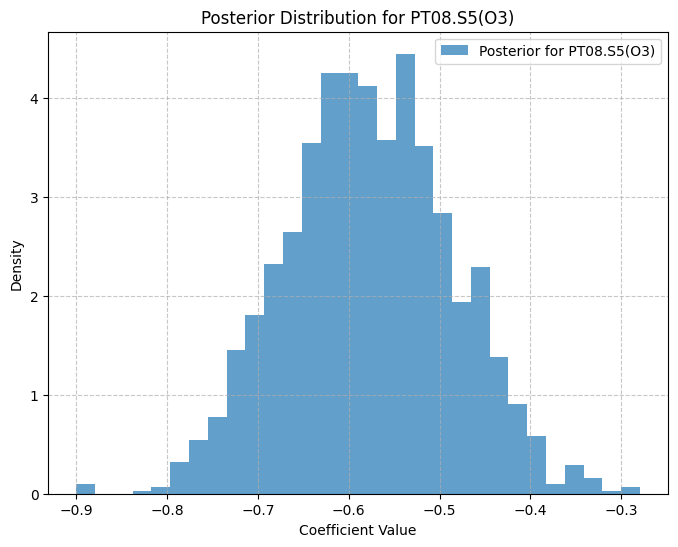

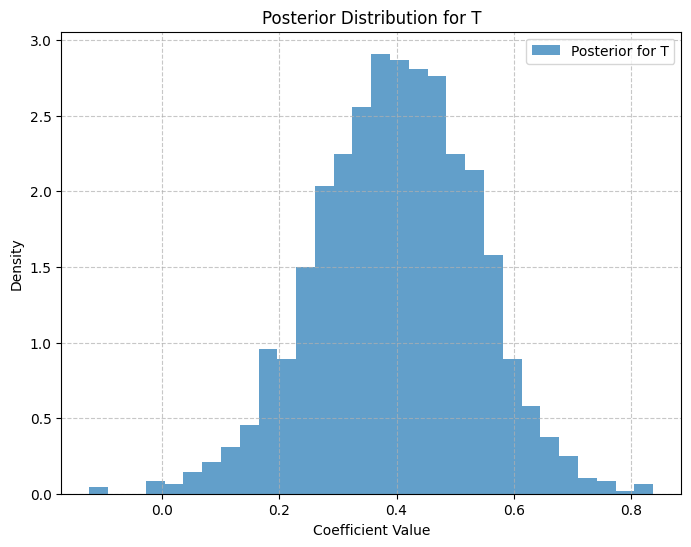

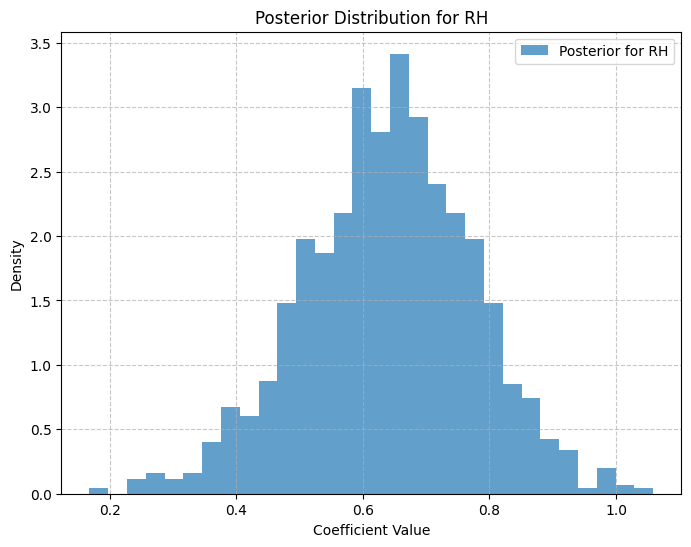

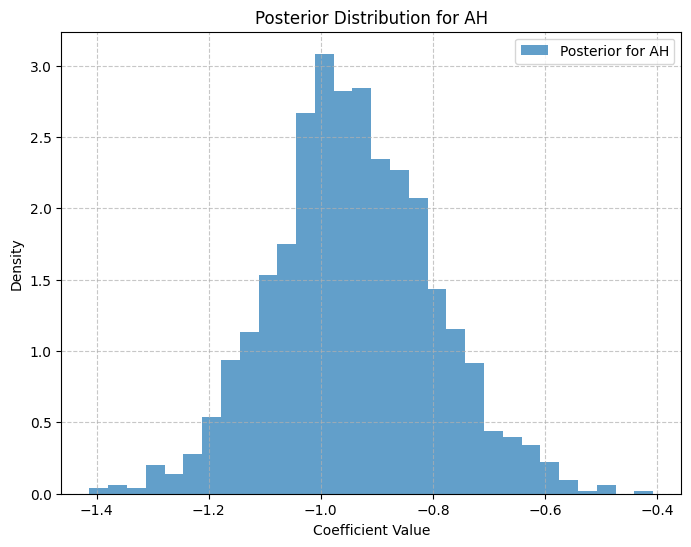

In [19]:
# Iterate through predictors and plot their posterior distributions
for i, predictor in enumerate(predictor_variables):
    # Extract posterior samples for the i-th predictor
    predictor_posterior = gamma_beta_posterior.sel(beta_dim_0=i).values.flatten()  # Convert to NumPy array

    # Plot the posterior distribution
    plt.figure(figsize=(8, 6))
    plt.hist(predictor_posterior, bins=30, density=True, alpha=0.7, label=f"Posterior for {predictor}")
    plt.title(f"Posterior Distribution for {predictor}")
    plt.xlabel("Coefficient Value")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()


In [20]:
# Summarize the posterior
# 95% credible interval
posterior_summary = az.summary(idata, var_names=["beta"], hdi_prob=0.95)
print(posterior_summary)

           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]  -0.681  0.180    -1.012     -0.322      0.005    0.004    1253.0   
beta[1]   0.727  0.127     0.492      0.983      0.003    0.002    1466.0   
beta[2]  -0.876  0.081    -1.037     -0.723      0.002    0.001    1482.0   
beta[3]   3.365  0.272     2.823      3.882      0.010    0.007     745.0   
beta[4]  -0.418  0.122    -0.644     -0.175      0.003    0.003    1302.0   
beta[5]  -3.298  0.110    -3.511     -3.086      0.004    0.003     734.0   
beta[6]   0.677  0.084     0.524      0.845      0.002    0.001    1629.0   
beta[7]  -0.749  0.241    -1.214     -0.271      0.007    0.005    1069.0   
beta[8]  -0.577  0.091    -0.754     -0.409      0.002    0.002    1765.0   
beta[9]   0.399  0.135     0.153      0.682      0.005    0.004     605.0   
beta[10]  0.640  0.135     0.359      0.885      0.005    0.004     630.0   
beta[11] -0.941  0.143    -1.205     -0.637      0.006    0.004     583.0   

In [21]:
# summary for posterior of gamma regression
posterior_summary

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]  -0.681  0.180    -1.012     -0.322      0.005    0.004    1253.0   
beta[1]   0.727  0.127     0.492      0.983      0.003    0.002    1466.0   
beta[2]  -0.876  0.081    -1.037     -0.723      0.002    0.001    1482.0   
beta[3]   3.365  0.272     2.823      3.882      0.010    0.007     745.0   
beta[4]  -0.418  0.122    -0.644     -0.175      0.003    0.003    1302.0   
beta[5]  -3.298  0.110    -3.511     -3.086      0.004    0.003     734.0   
beta[6]   0.677  0.084     0.524      0.845      0.002    0.001    1629.0   
beta[7]  -0.749  0.241    -1.214     -0.271      0.007    0.005    1069.0   
beta[8]  -0.577  0.091    -0.754     -0.409      0.002    0.002    1765.0   
beta[9]   0.399  0.135     0.153      0.682      0.005    0.004     605.0   
beta[10]  0.640  0.135     0.359      0.885      0.005    0.004     630.0   
beta[11] -0.941  0.143    -1.205     -0.637      0.006    0.004     583.0   

          ess_tail  r_hat  
beta[0]     1124.0   1.00  
beta[1]     1252.0   1.00  
beta[2]     1116.0   1.00  
beta[3]      996.0   1.01  
beta[4]     1118.0   1.00  
beta[5]     1098.0   1.00  
beta[6]     1088.0   1.00  
beta[7]     1184.0   1.00  
beta[8]     1223.0   1.00  
beta[9]      854.0   1.00  
beta[10]     904.0   1.00  
beta[11]     838.0   1.00

In [22]:
prior_gamma_beta_values.shape

(500, 12)

In [23]:
idata.posterior["beta"].values.shape

(3, 500, 12)

In [24]:
len(gamma_beta_posterior)

3

In [25]:
posterior_gamma_beta_values = []
for i, _ in enumerate(range(len(gamma_beta_posterior))):
    posterior_gamma_beta_values.append(gamma_beta_posterior[i].shape)
    # = idata.posterior["beta"].values.flatten() #.sel(beta_dim_0=i)
# posterior_gamma_beta_values.shape

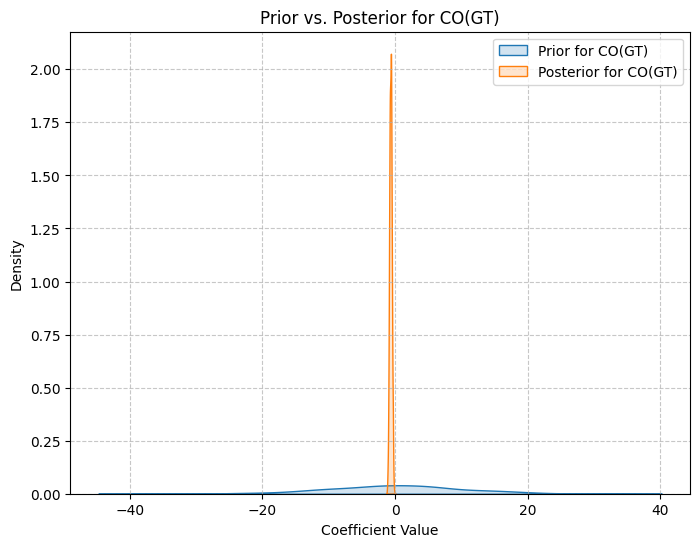

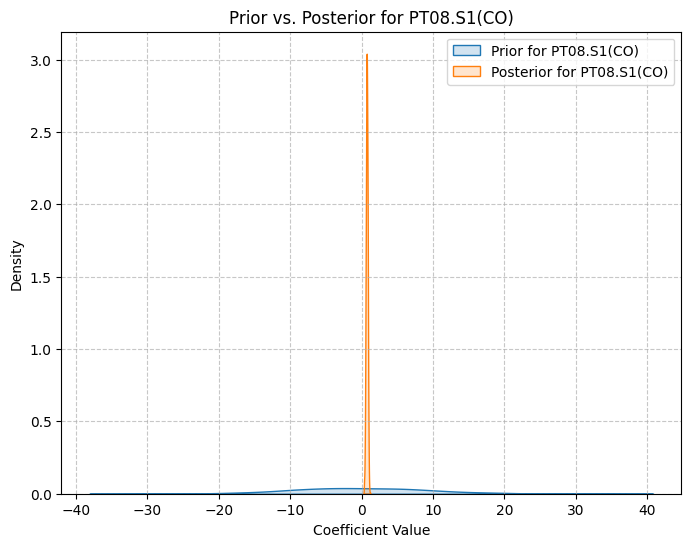

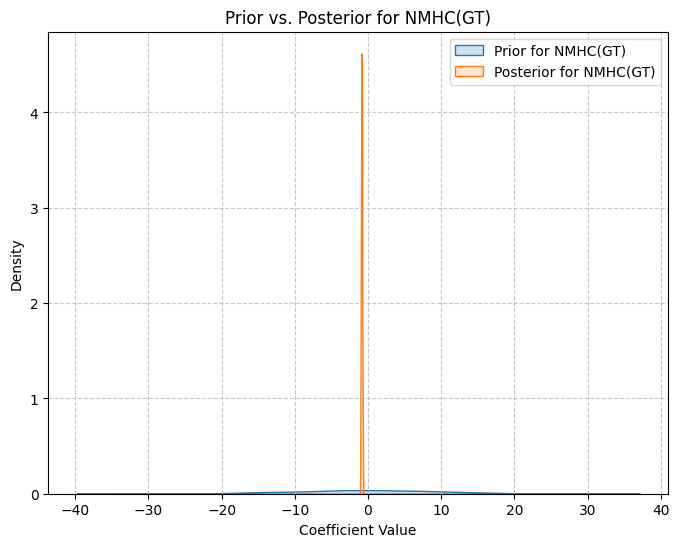

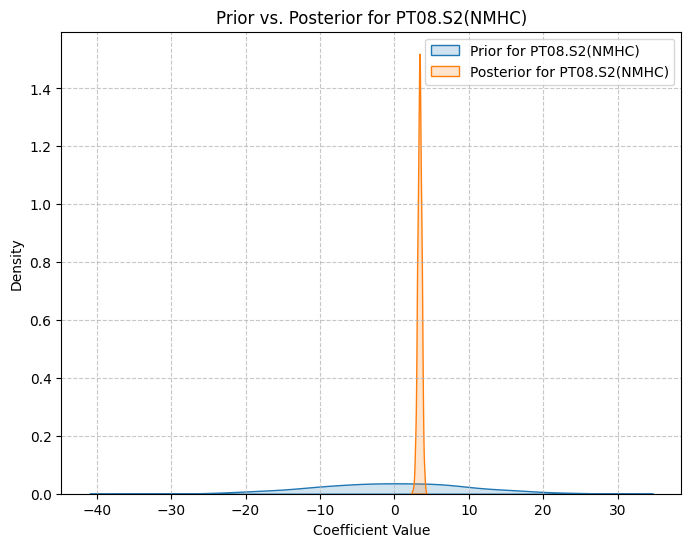

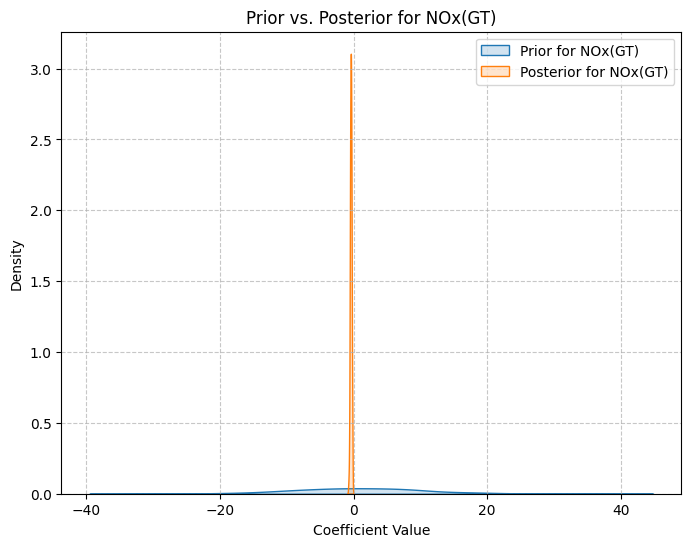

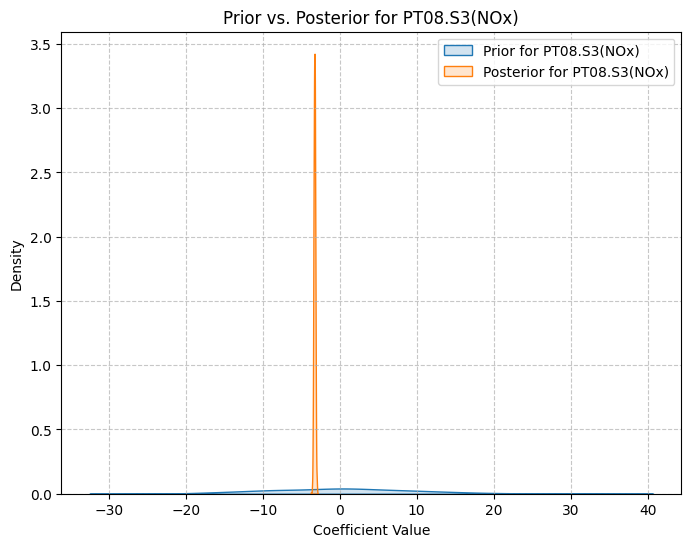

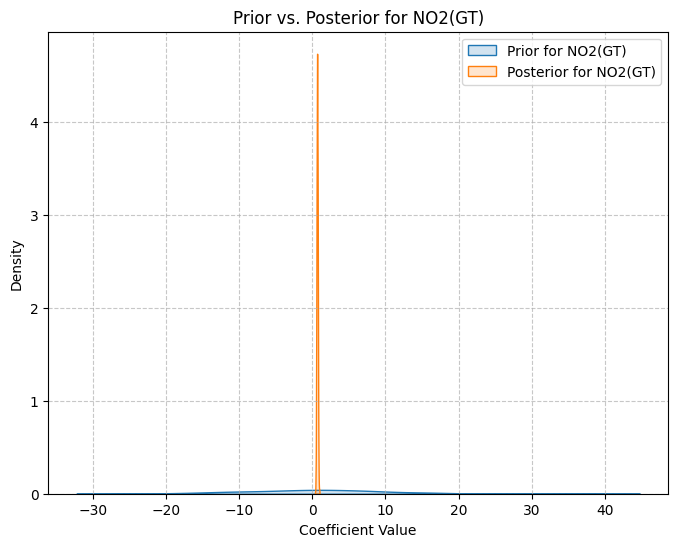

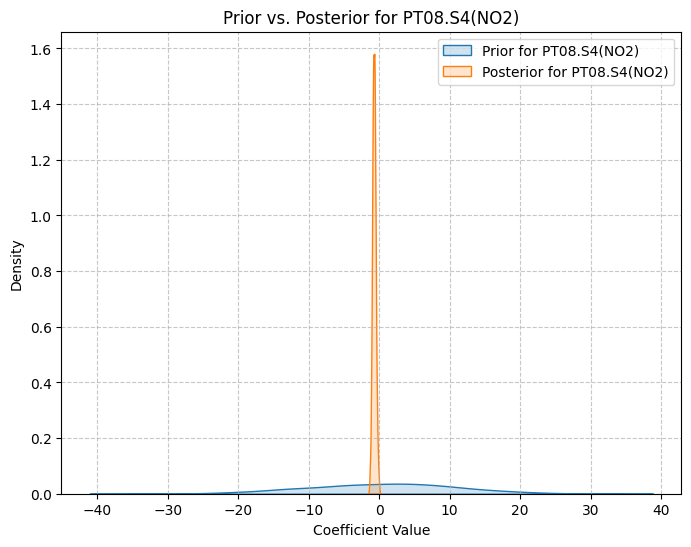

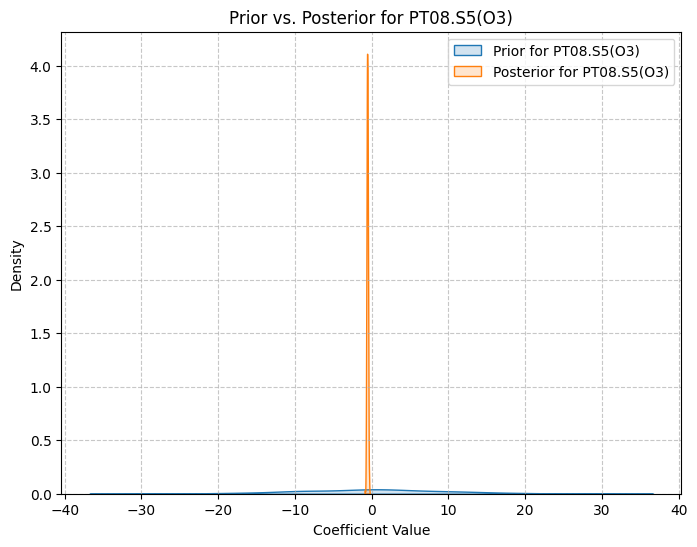

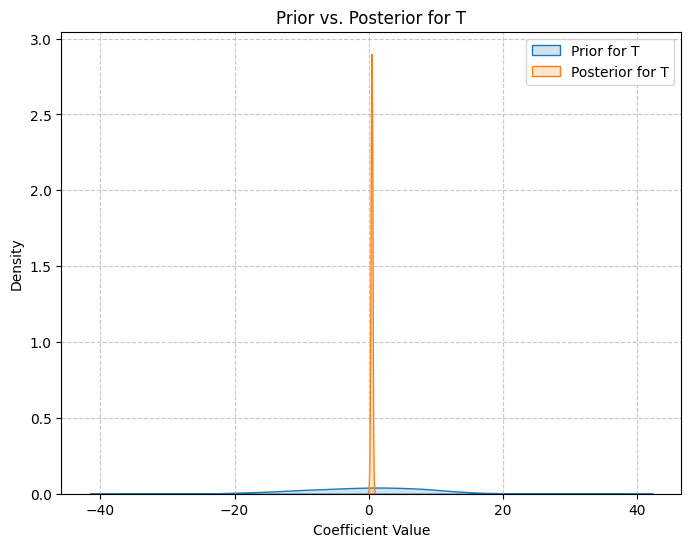

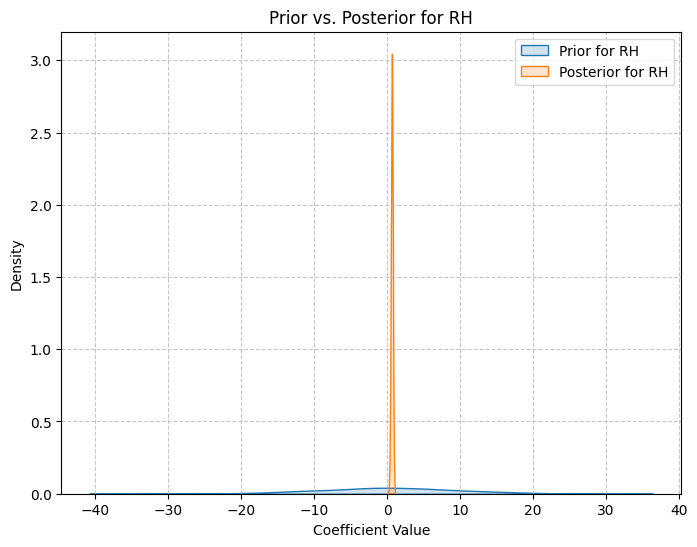

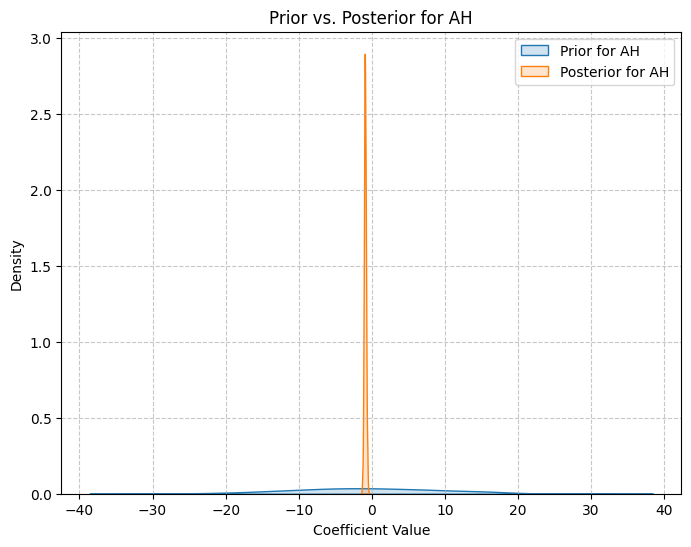

In [26]:
for i, predictor_name in enumerate(predictor_variables):
    # for posterior_gamma_beta in posterior_gamma_beta_values:
    # Extract prior and posterior for each predictor
    prior_samples = prior_gamma_beta_values[:, i]
    posterior_samples = idata.posterior["beta"].sel(beta_dim_0=i).values.flatten()
    # posterior_samples = idata.posterior["beta"].values.reshape((-1, idata.posterior["beta"].values.shape[1], idata.posterior["beta"].values.shape[2]))
    #idata.posterior["beta"].sel(beta_dim_0=i)#.values.flatten() #posterior_gamma_beta_values#
    # gamma_beta_posterior.sel(beta_dim_0=i).values.flatten()

    # Plot prior vs. posterior
    plt.figure(figsize=(8, 6))#(8, 6)
    # plt.hist(prior_samples, bins=100, density=True, alpha=0.5, label=f"Prior for {predictor_name}")
    # plt.hist(posterior_samples, bins=100, density=True, alpha=0.5, label=f"Posterior for {predictor_name}")
    sns.kdeplot(prior_samples, fill=True, alpha=0.2, label=f"Prior for {predictor_name}")
    sns.kdeplot(posterior_samples, fill=True, alpha=0.2, label=f"Posterior for {predictor_name}")
    plt.title(f"Prior vs. Posterior for {predictor_name}")
    plt.xlabel("Coefficient Value")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()


Gamma Model Evaluation

In [27]:
with gamma_model:
    # log_likelihood_gamma = 
    pm.compute_log_likelihood(idata)

Output()

In [30]:
# Compute WAIC and LOO for Model Comparison
try:
    # Compute WAIC
    waic = az.waic(idata)
    print(f"WAIC: {waic}")

    # Compute LOO
    gamma_loo = az.loo(idata)
    print(f"LOO: {loo}")

except Exception as e:
    print("Error in computing WAIC/LOO:", str(e))

WAIC: Computed from 1500 posterior samples and 827 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  1698.57    64.13
p_waic       26.48        -

There has been a warning during the calculation. Please check the results.
LOO: Computed from 1500 posterior samples and 827 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  1698.43    64.11
p_loo       26.62        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.69]   (good)      825   99.8%
   (0.69, 1]   (bad)         1    0.1%
   (1, Inf)   (very bad)    1    0.1%



Student t-model

Student t-model: Prior

In [97]:
# Define the Student-t model structure for prior sampling
with pm.Model() as student_t_prior_model:
    # Priors for coefficients, intercept, and degrees of freedom
    beta = pm.Normal("beta", mu=0, sigma=10, shape=X.shape[1])  # Coefficients for predictors
    intercept = pm.Normal("intercept", mu=0, sigma=10)  # Intercept
    nu = pm.Exponential("nu", 1.0)  # Degrees of freedom (Student-t)

    # Linear predictor
    mu = pm.math.dot(X, beta) + intercept

    # Likelihood (without observed data for prior predictive checks)
    target = pm.StudentT("target", nu=nu, mu=mu, sigma=1.0)

    # Sample from the prior predictive distribution
    student_prior_predictive = pm.sample_prior_predictive()


Sampling: [beta, intercept, nu, target]


In [100]:
student_prior_beta_shape = student_prior_predictive["prior"]["beta"].shape
student_prior_beta_shape

(1, 500, 12)

In [102]:
student_prior_beta_values = student_prior_predictive["prior"]["beta"].values.reshape(
    student_prior_beta_shape[1], student_prior_beta_shape[2])
student_prior_beta_values.shape

(500, 12)

In [110]:
student_prior_intercept = student_prior_predictive["prior"]["intercept"].values.flatten()

In [112]:
student_prior_nu = student_prior_predictive["prior"]["nu"].values.flatten()
type(student_prior_nu)

numpy.ndarray

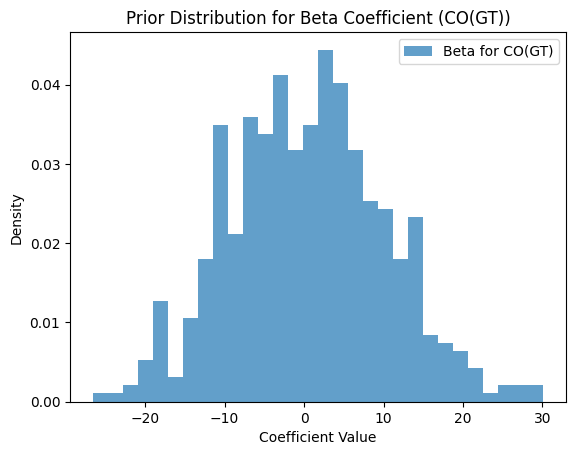

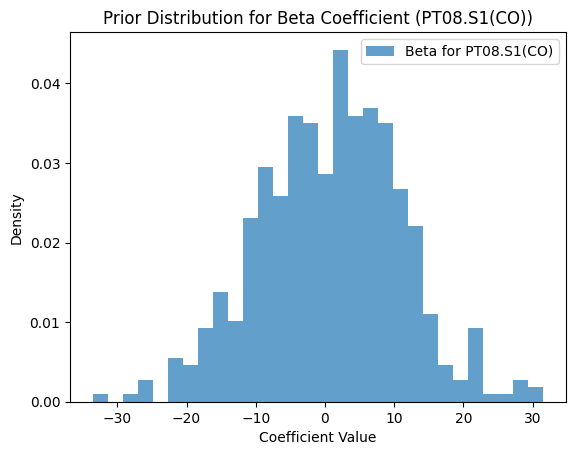

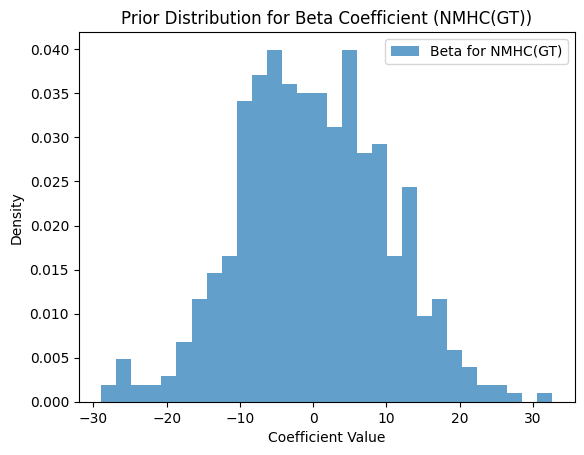

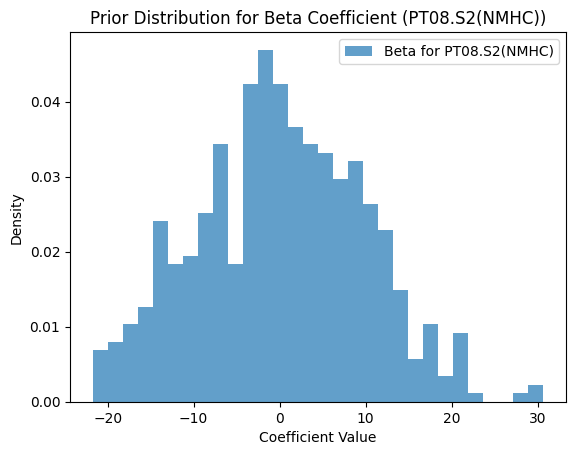

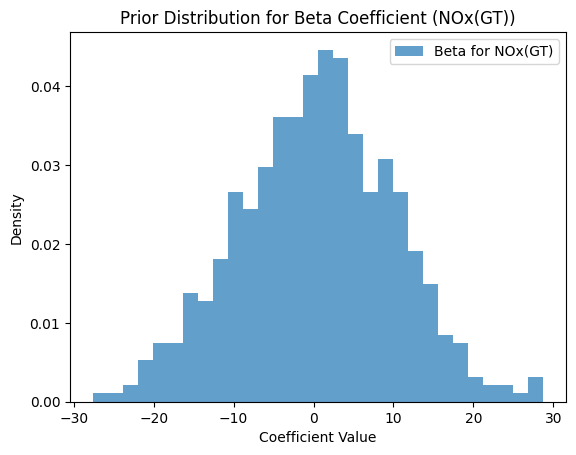

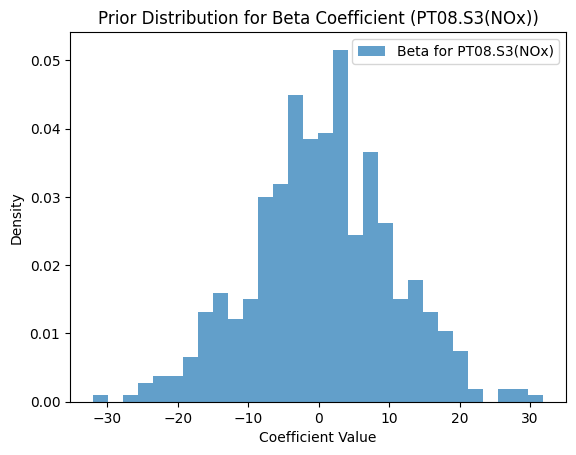

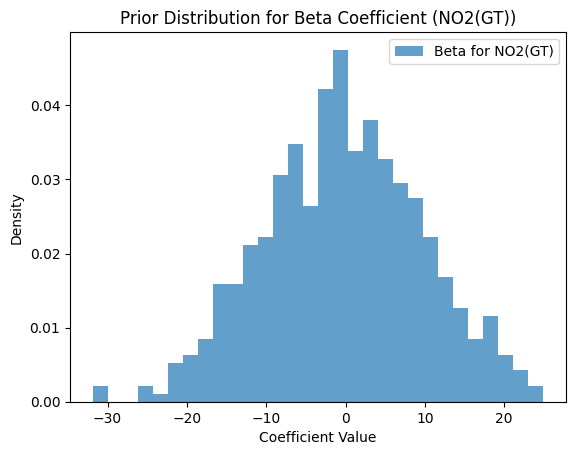

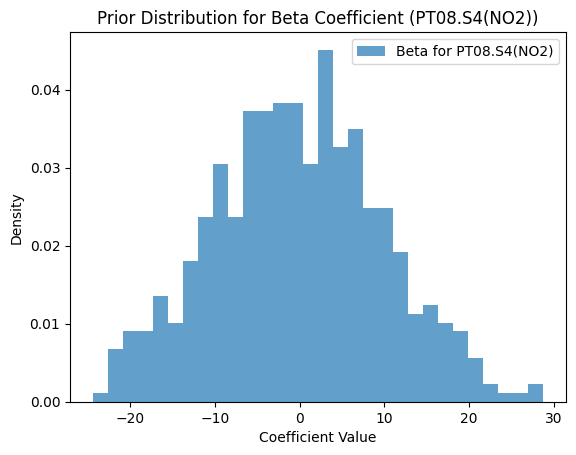

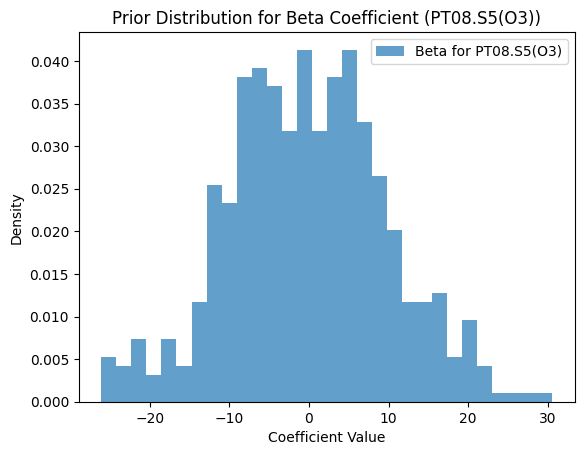

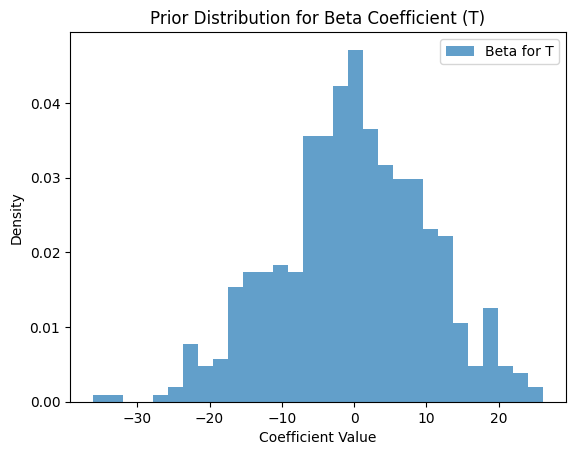

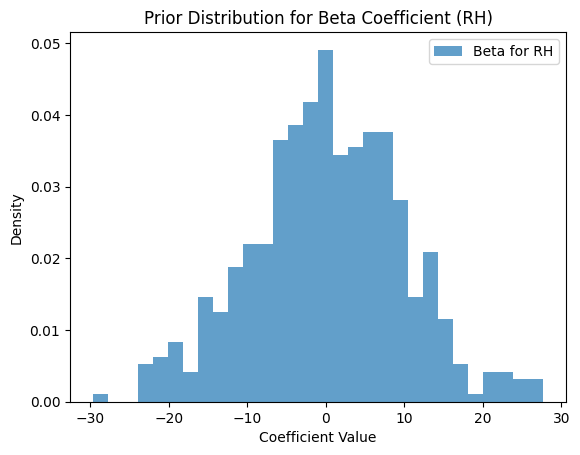

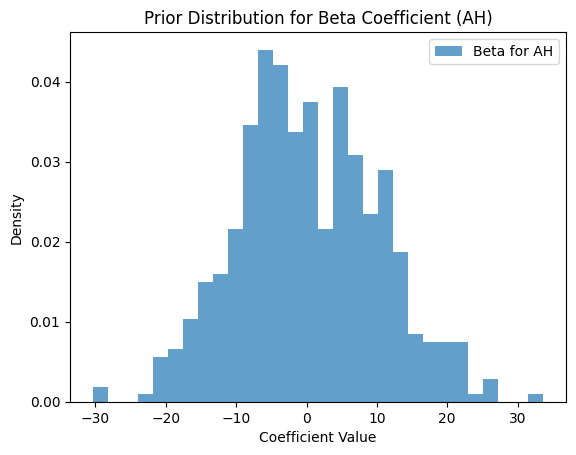

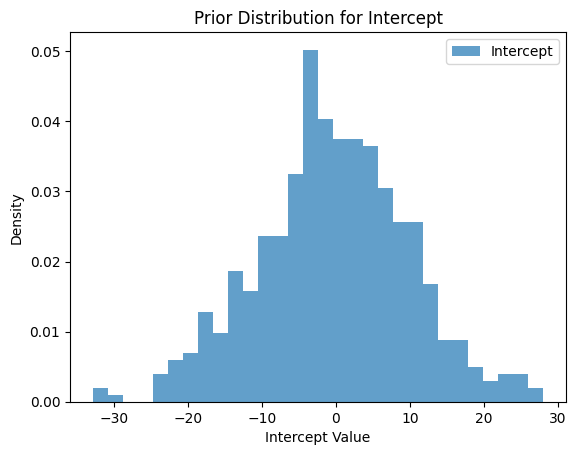

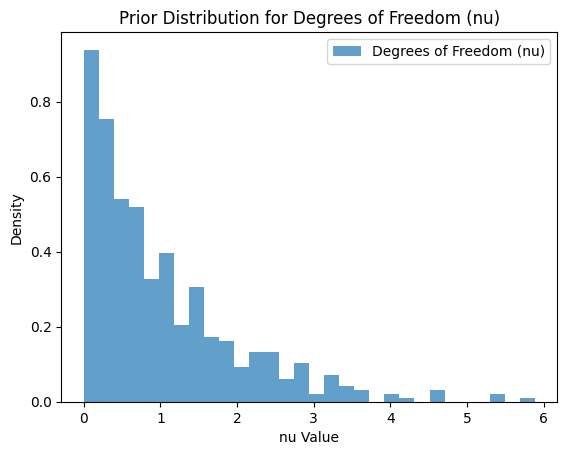

In [114]:
# Plot prior for coefficients (beta)
for i, predictor in enumerate(predictor_columns):
    plt.hist(student_prior_beta_values[:, i], bins=30, density=True, alpha=0.7, label=f"Beta for {predictor}")
    plt.title(f"Prior Distribution for Beta Coefficient ({predictor})")
    plt.xlabel("Coefficient Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

# Plot prior for intercept
plt.hist(student_prior_intercept, bins=30, density=True, alpha=0.7, label="Intercept")
plt.title("Prior Distribution for Intercept")
plt.xlabel("Intercept Value")
plt.ylabel("Density")
plt.legend()
plt.show()

# Plot prior for degrees of freedom (nu)
plt.hist(student_prior_nu, bins=30, density=True, alpha=0.7, label="Degrees of Freedom (nu)")
plt.title("Prior Distribution for Degrees of Freedom (nu)")
plt.xlabel("nu Value")
plt.ylabel("Density")
plt.legend()
plt.show()


In [117]:
with pm.Model() as student_t_model:
    beta = pm.Normal("beta", mu=0, sigma=10, shape=X.shape[1])
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    nu = pm.Exponential("nu", 1.0)  # Degrees of freedom
    mu = pm.math.dot(X, beta) + intercept
    target = pm.StudentT("target", nu=nu, mu=mu, sigma=1.0, observed=y)
    trace_student_t = pm.sample(500, tune=500, return_inferencedata=True)
    student_posterior_predictive = pm.sample_posterior_predictive(trace_student_t, model=student_t_model)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [beta, intercept, nu]


Output()

Sampling 3 chains for 500 tune and 500 draw iterations (1_500 + 1_500 draws total) took 46 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [target]


Output()

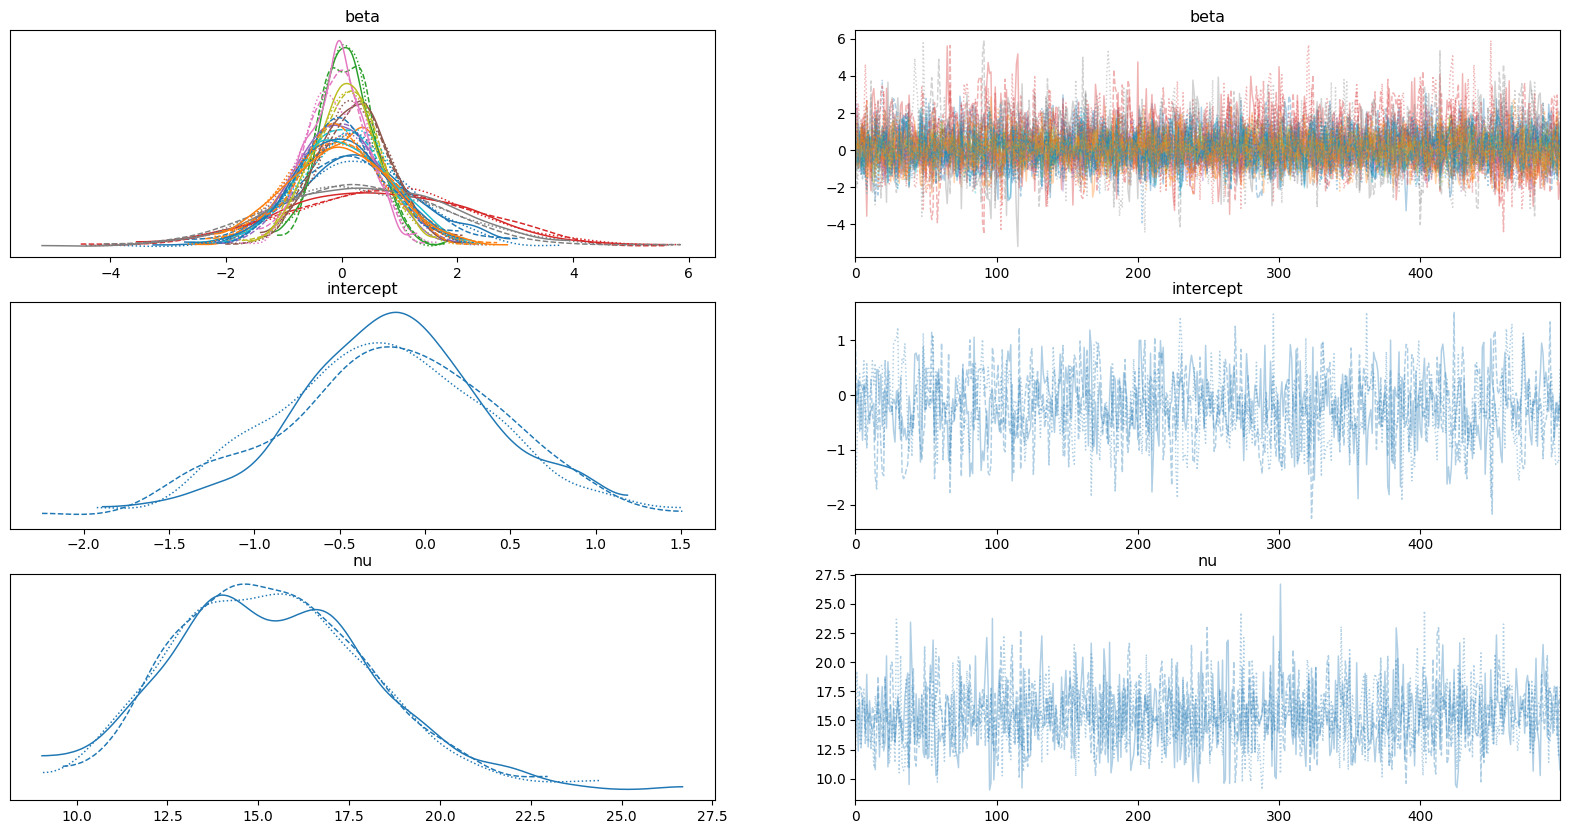

In [118]:
# Save and display posterior diagnostics
# posterior_summary = az.summary(student_t_summary)
az.plot_trace(trace_student_t, figsize=(20, 10), compact=True) #, var_names=scaled_data.columns
# plt.savefig("traceplot_beta_intercept_alpha.png")
plt.show()

In [123]:
trace_student_t

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

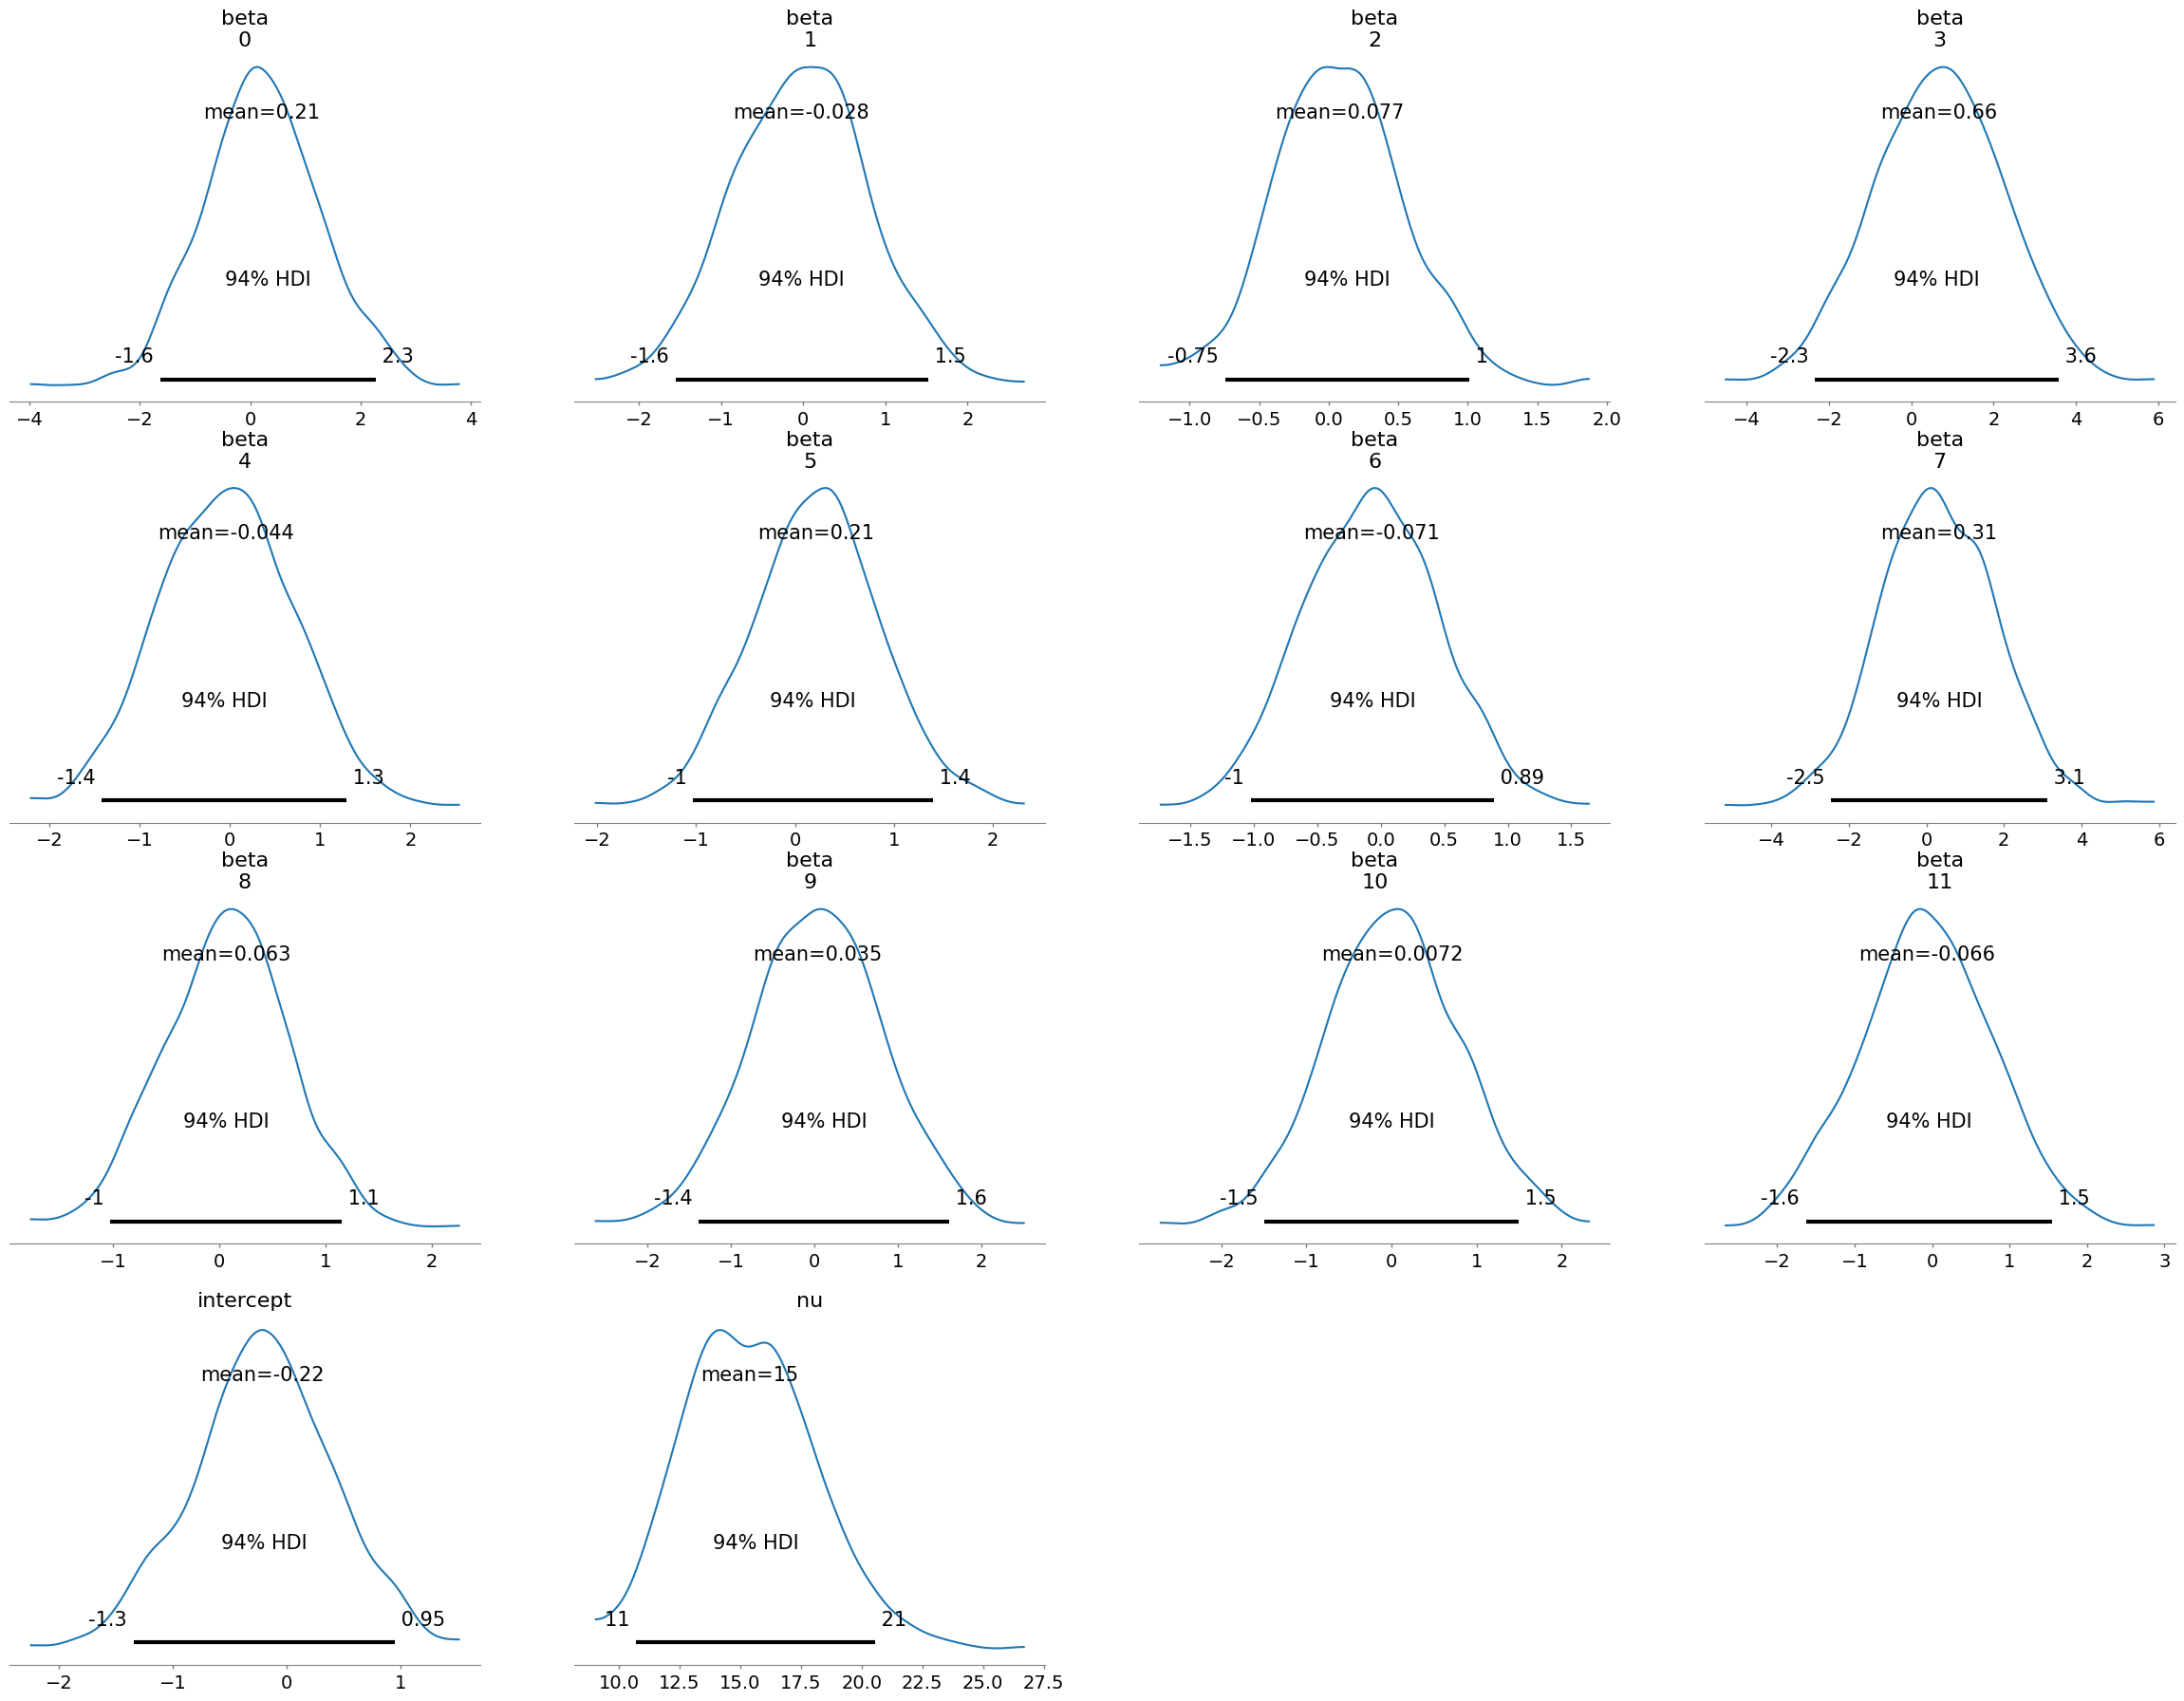

In [124]:
az.plot_posterior(trace_student_t.posterior)
# plt.savefig("posterior_beta_intercept_alpha.png")
plt.show()

In [126]:
student_beta_posterior = trace_student_t.posterior["beta"]

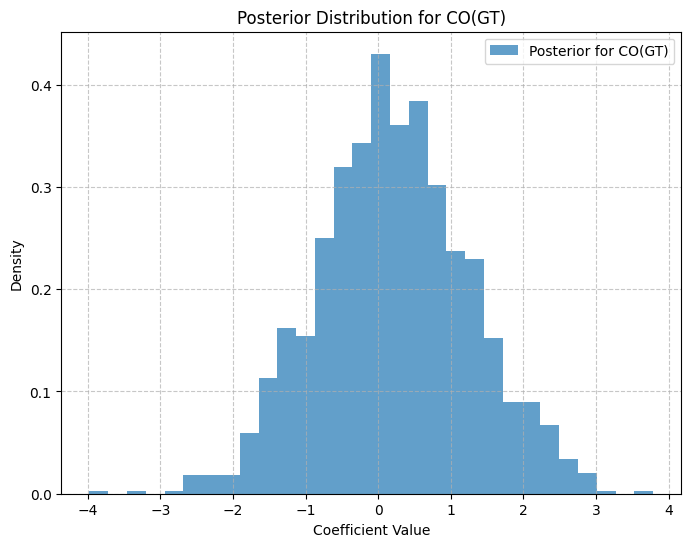

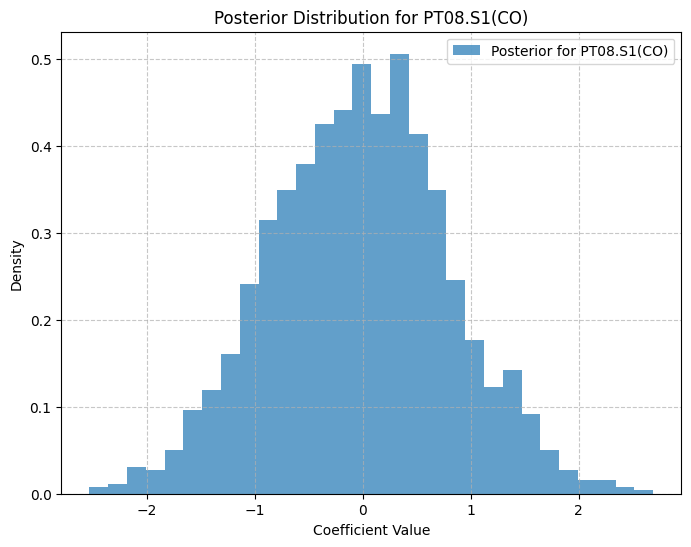

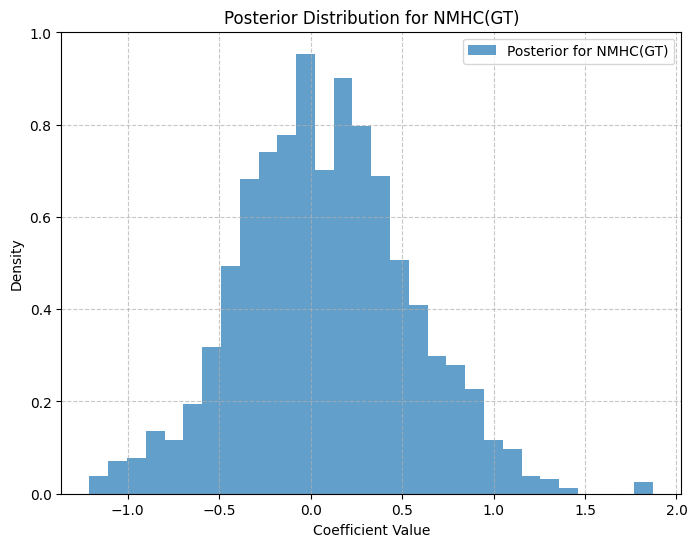

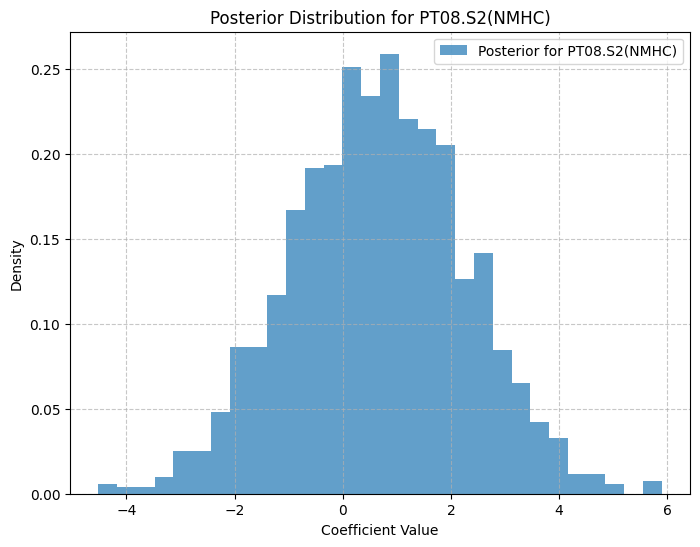

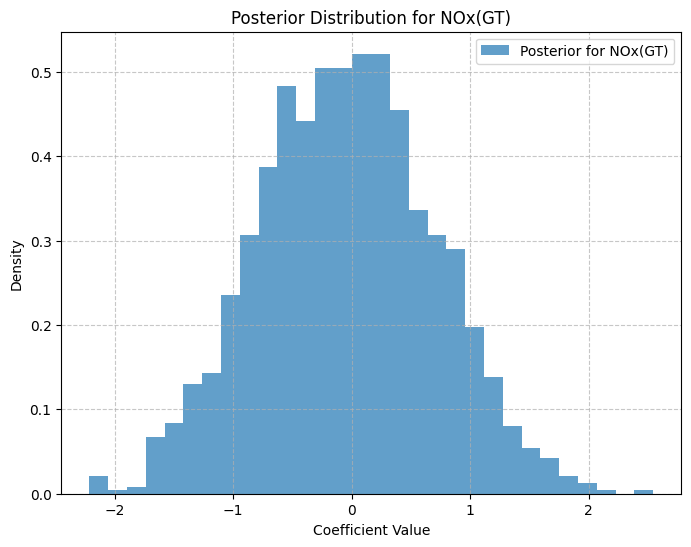

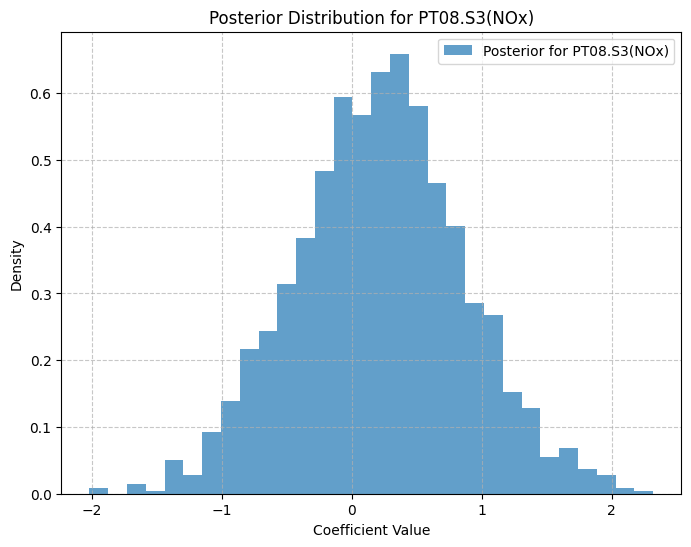

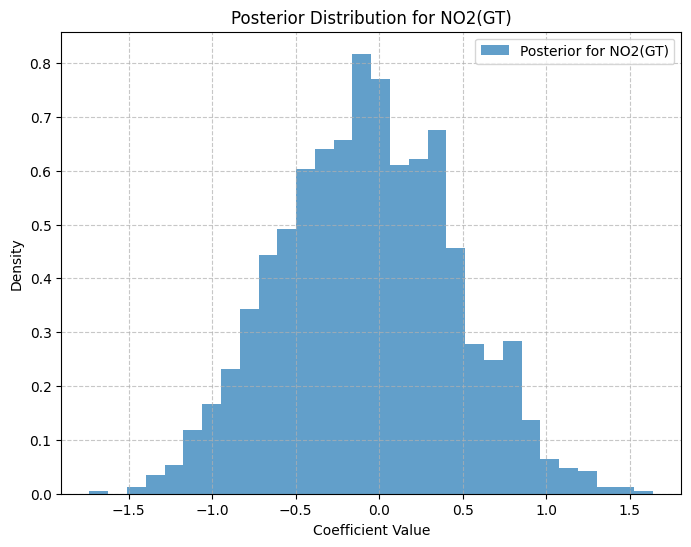

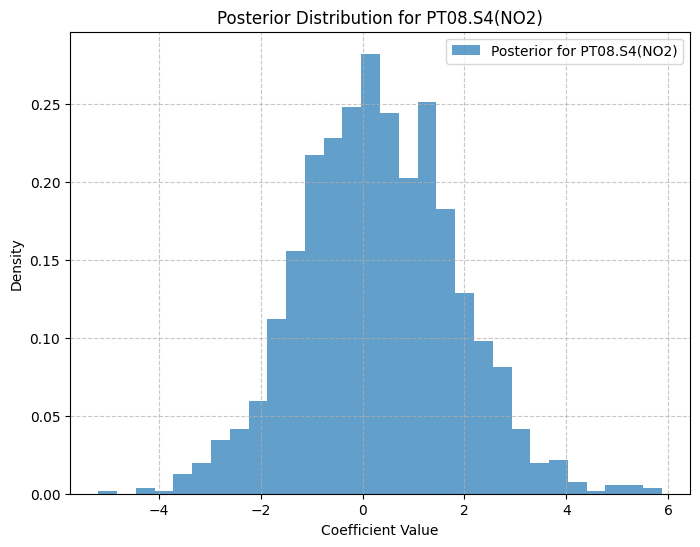

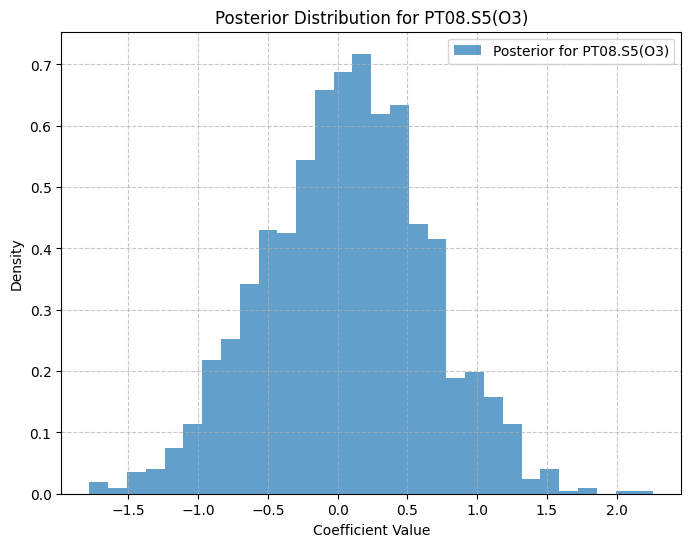

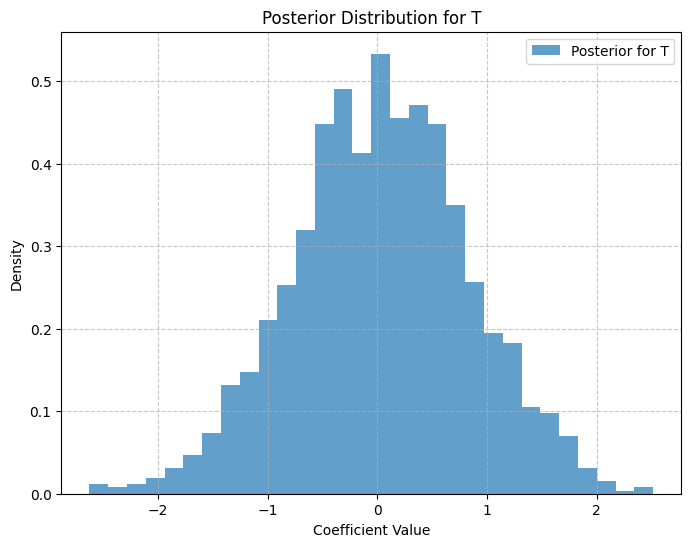

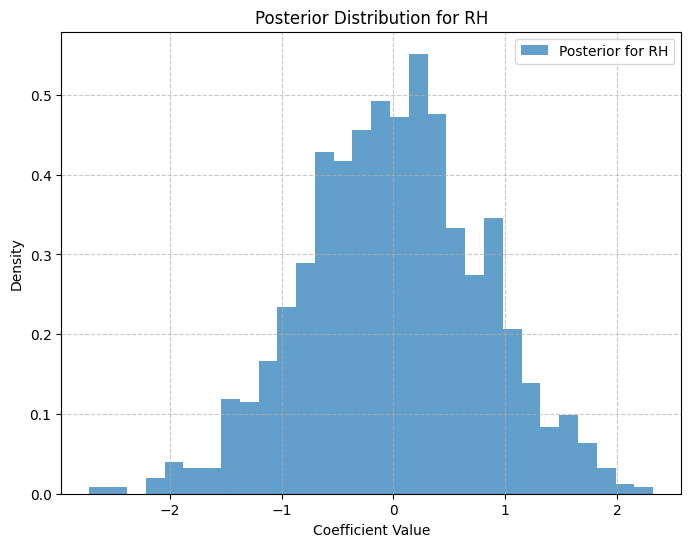

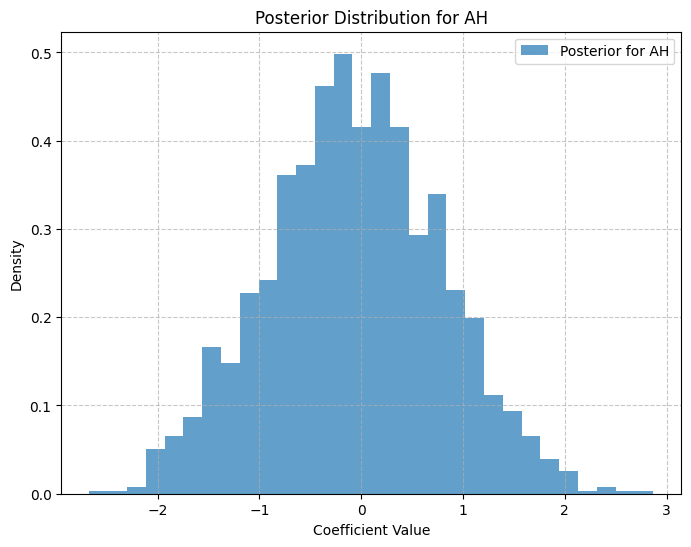

In [127]:
# Iterate through predictors and plot their posterior distributions
for i, predictor in enumerate(predictor_variables):
    # Extract posterior samples for the i-th predictor
    student_beta_predictor_posterior = student_beta_posterior.sel(beta_dim_0=i).values.flatten()  # Convert to NumPy array

    # Plot the posterior distribution
    plt.figure(figsize=(8, 6))
    plt.hist(student_beta_predictor_posterior, bins=30, density=True, alpha=0.7, label=f"Posterior for {predictor}")
    plt.title(f"Posterior Distribution for {predictor}")
    plt.xlabel("Coefficient Value")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()

In [129]:
# Summarize the posterior
# 95% credible interval
student_posterior_summary = az.summary(trace_student_t, var_names=["beta"], hdi_prob=0.95)
print(student_posterior_summary)

           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]   0.215  1.043    -1.755      2.275      0.030    0.023    1189.0   
beta[1]  -0.028  0.825    -1.636      1.562      0.022    0.020    1407.0   
beta[2]   0.077  0.468    -0.845      0.990      0.013    0.011    1419.0   
beta[3]   0.661  1.608    -2.478      3.712      0.059    0.042     742.0   
beta[4]  -0.044  0.734    -1.502      1.312      0.018    0.017    1612.0   
beta[5]   0.213  0.648    -1.066      1.464      0.024    0.017     722.0   
beta[6]  -0.071  0.520    -1.071      0.913      0.013    0.015    1564.0   
beta[7]   0.309  1.509    -2.725      3.143      0.046    0.037    1070.0   
beta[8]   0.063  0.587    -1.025      1.235      0.015    0.016    1541.0   
beta[9]   0.035  0.803    -1.595      1.544      0.030    0.021     719.0   
beta[10]  0.007  0.792    -1.566      1.518      0.029    0.021     737.0   
beta[11] -0.066  0.849    -1.785      1.515      0.033    0.024     651.0   

In [130]:
student_posterior_summary

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]   0.215  1.043    -1.755      2.275      0.030    0.023    1189.0   
beta[1]  -0.028  0.825    -1.636      1.562      0.022    0.020    1407.0   
beta[2]   0.077  0.468    -0.845      0.990      0.013    0.011    1419.0   
beta[3]   0.661  1.608    -2.478      3.712      0.059    0.042     742.0   
beta[4]  -0.044  0.734    -1.502      1.312      0.018    0.017    1612.0   
beta[5]   0.213  0.648    -1.066      1.464      0.024    0.017     722.0   
beta[6]  -0.071  0.520    -1.071      0.913      0.013    0.015    1564.0   
beta[7]   0.309  1.509    -2.725      3.143      0.046    0.037    1070.0   
beta[8]   0.063  0.587    -1.025      1.235      0.015    0.016    1541.0   
beta[9]   0.035  0.803    -1.595      1.544      0.030    0.021     719.0   
beta[10]  0.007  0.792    -1.566      1.518      0.029    0.021     737.0   
beta[11] -0.066  0.849    -1.785      1.515      0.033    0.024     651.0   

          ess_tail  r_hat  
beta[0]     1048.0   1.00  
beta[1]      949.0   1.00  
beta[2]     1149.0   1.00  
beta[3]     1033.0   1.00  
beta[4]     1212.0   1.00  
beta[5]      951.0   1.00  
beta[6]     1011.0   1.01  
beta[7]     1058.0   1.00  
beta[8]     1094.0   1.00  
beta[9]      849.0   1.00  
beta[10]     898.0   1.00  
beta[11]     802.0   1.00

In [ ]:
student_prior_beta_values

In [ ]:
trace_student_t.posterior["beta"]

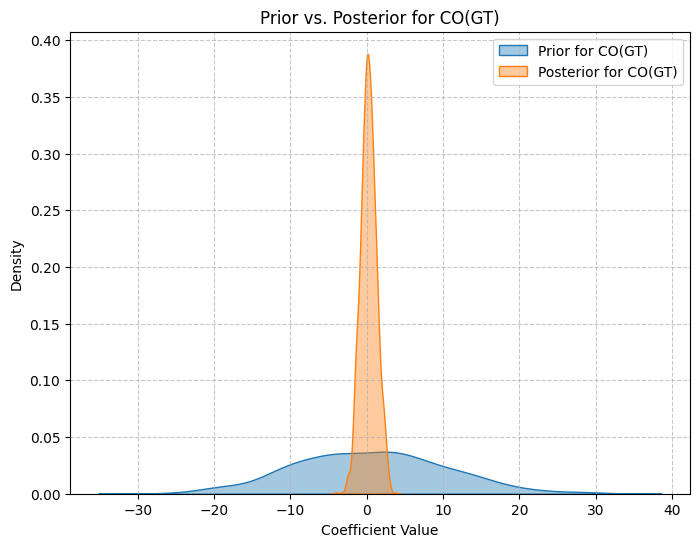

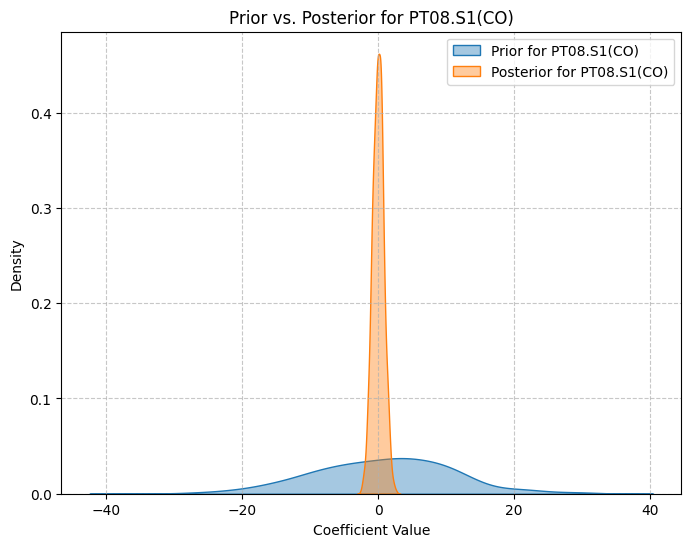

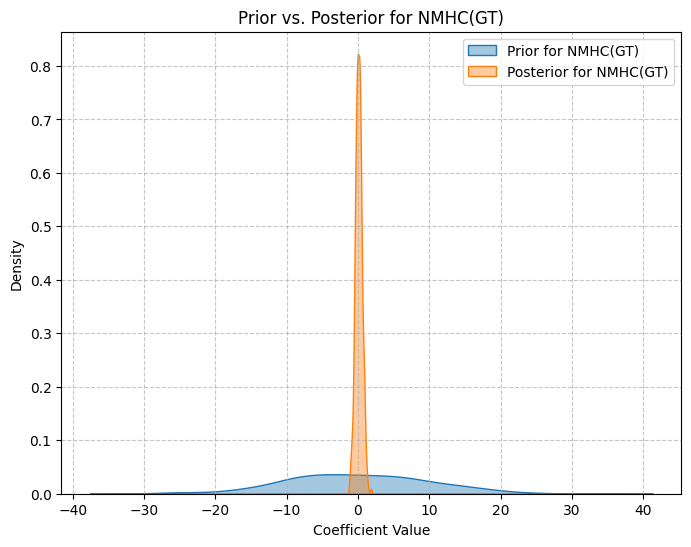

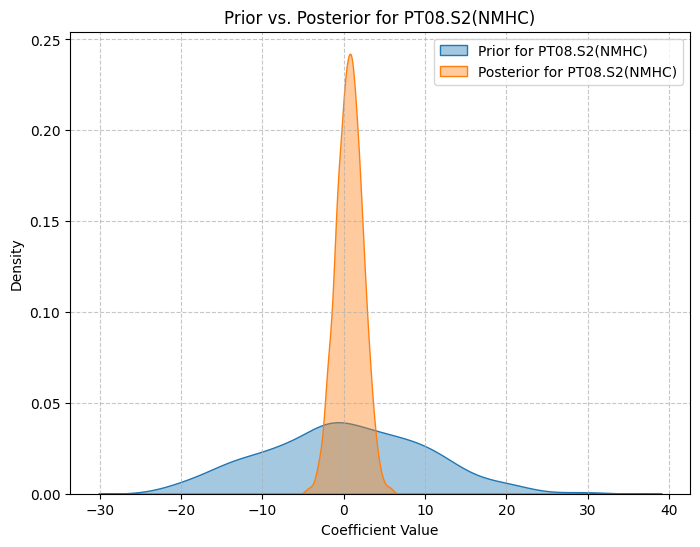

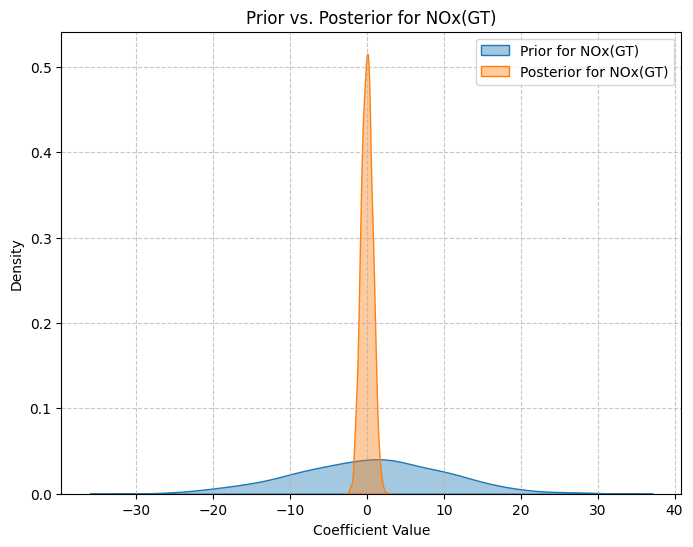

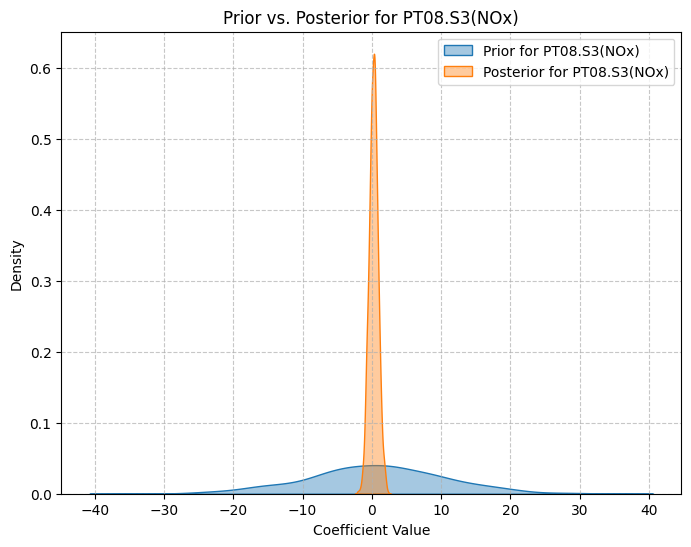

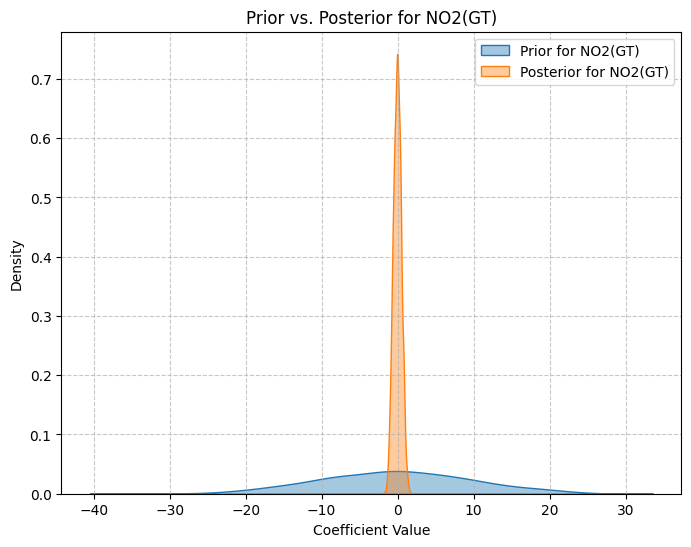

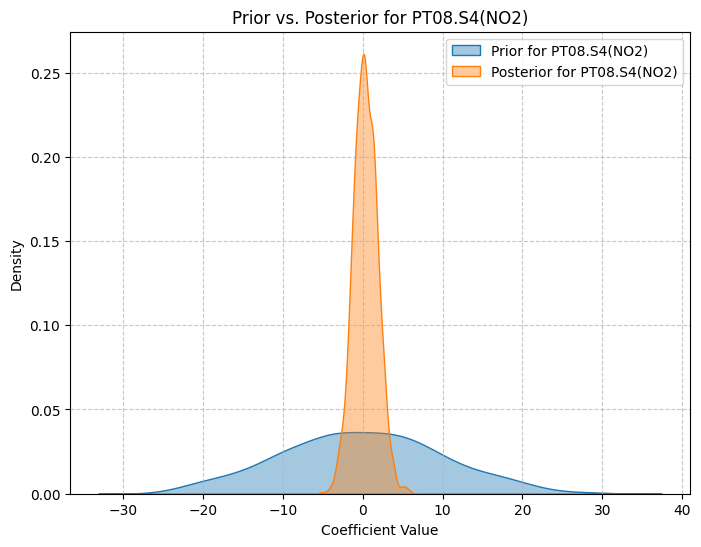

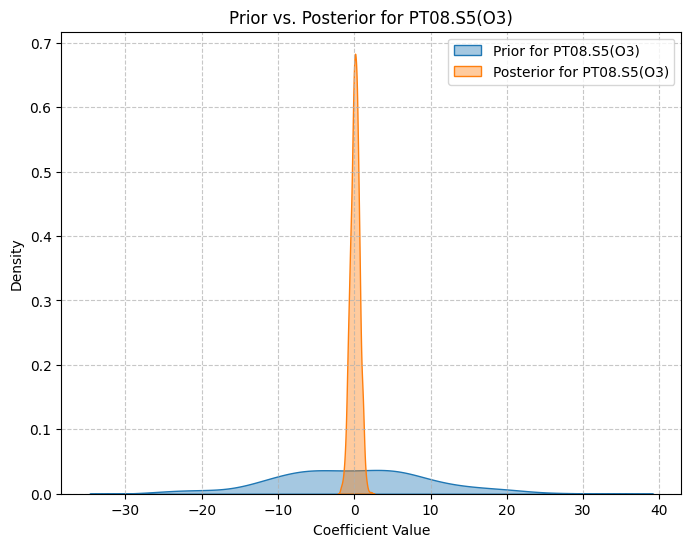

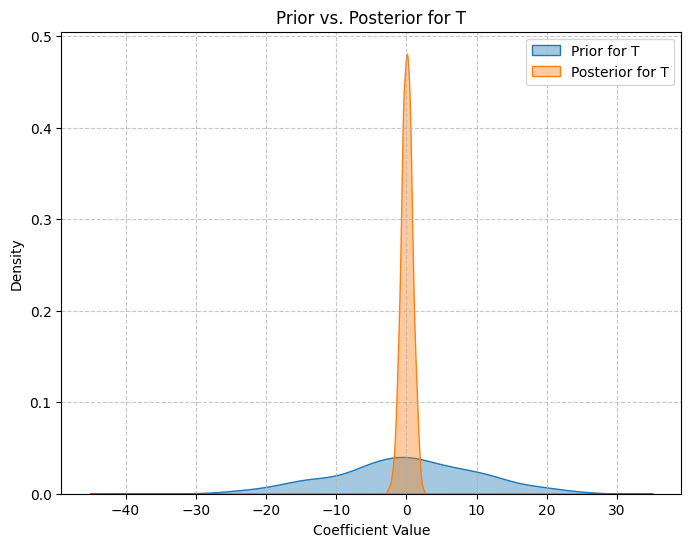

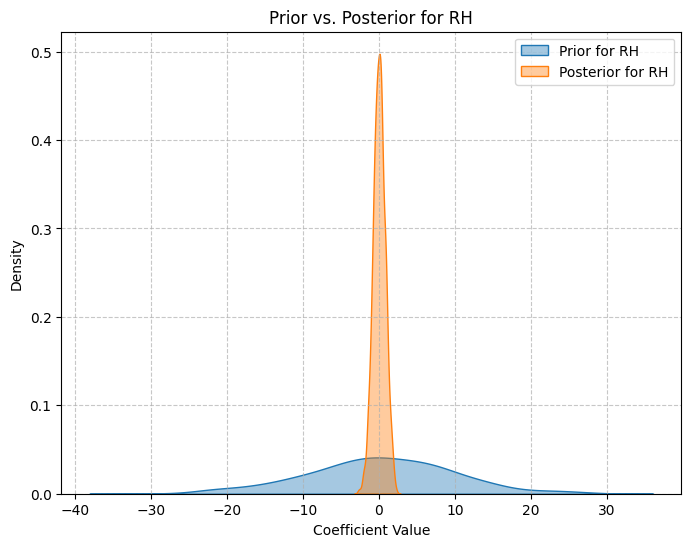

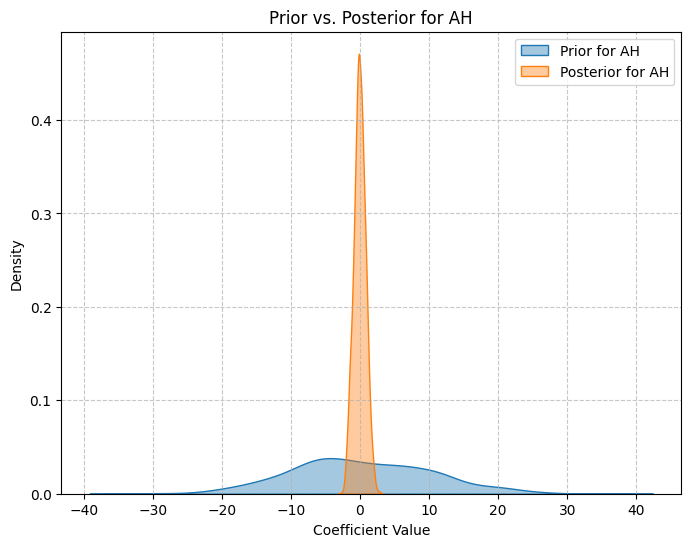

In [132]:
for i, predictor_name in enumerate(predictor_variables):
    # for posterior_gamma_beta in posterior_gamma_beta_values:
    # Extract prior and posterior for each predictor
    prior_samples = student_prior_beta_values[:, i]
    posterior_samples = trace_student_t.posterior["beta"].sel(beta_dim_0=i).values.flatten()
    # posterior_samples = idata.posterior["beta"].values.reshape((-1, idata.posterior["beta"].values.shape[1], idata.posterior["beta"].values.shape[2]))
    #idata.posterior["beta"].sel(beta_dim_0=i)#.values.flatten() #posterior_gamma_beta_values#
    # gamma_beta_posterior.sel(beta_dim_0=i).values.flatten()

    # Plot prior vs. posterior
    plt.figure(figsize=(8, 6))#(8, 6)
    # plt.hist(prior_samples, bins=100, density=True, alpha=0.5, label=f"Prior for {predictor_name}")
    # plt.hist(posterior_samples, bins=100, density=True, alpha=0.5, label=f"Posterior for {predictor_name}")
    sns.kdeplot(prior_samples, fill=True, alpha=0.4, label=f"Prior for {predictor_name}")
    sns.kdeplot(posterior_samples, fill=True, alpha=0.4, label=f"Posterior for {predictor_name}")
    plt.title(f"Prior vs. Posterior for {predictor_name}")
    plt.xlabel("Coefficient Value")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()


In [133]:
with student_t_model:
    # log_likelihood_gamma = 
    pm.compute_log_likelihood(trace_student_t)

Output()

In [134]:
# Compute WAIC and LOO for Model Comparison
try:
    # Compute WAIC
    waic = az.waic(trace_student_t)
    print(f"WAIC: {waic}")

    # Compute LOO
    gamma_loo = az.loo(trace_student_t)
    print(f"LOO: {loo}")

except Exception as e:
    print("Error in computing WAIC/LOO:", str(e))

WAIC: Computed from 1500 posterior samples and 827 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -780.36     0.22
p_waic        0.19        -
LOO: Computed from 1500 posterior samples and 827 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  1698.43    64.11
p_loo       26.62        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.69]   (good)      825   99.8%
   (0.69, 1]   (bad)         1    0.1%
   (1, Inf)   (very bad)    1    0.1%



Hierarchical model (Grouping Check)

In [26]:
# Load the dataset
data_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "dataset")
data = pd.read_excel(f"{data_path}/data_transformed.xlsx")
# Drop the unnamed column as it is unnecessary for correlation analysis
data = data.drop(columns=['Unnamed: 0'])

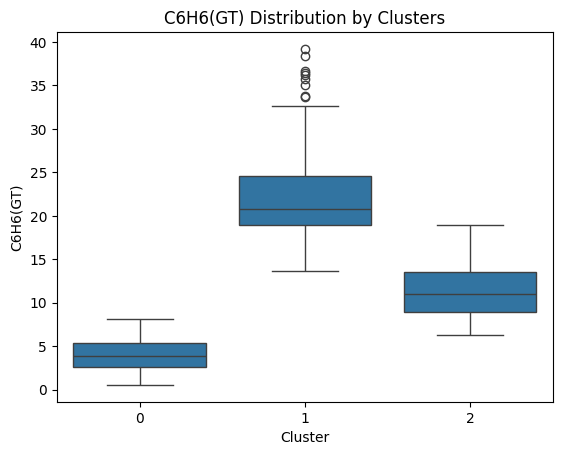

In [27]:
# Select relevant predictors for clustering (ignoring non-informative columns like 'Unnamed: 0')
predictor_columns = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 
                    'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

# Standardize the predictor variables for clustering
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(data[predictor_columns])

# Apply K-Means clustering to find natural groups in the data
kmeans = KMeans(n_clusters=3, random_state=42)  # Choose 3 clusters as an example
data['cluster'] = kmeans.fit_predict(scaled_features)

# Visualize the distribution of the target variable within the clusters
sns.boxplot(x='cluster', y='C6H6(GT)', data=data)
plt.title("C6H6(GT) Distribution by Clusters")
plt.xlabel("Cluster")
plt.ylabel("C6H6(GT)")
plt.show()

# Summary statistics for each cluster
cluster_summary = data.groupby("cluster")[predictor_columns + ['C6H6(GT)']].mean()

In [30]:
cluster_summary.head()

CO(GT)  PT08.S1(CO)    NMHC(GT)  PT08.S2(NMHC)     NOx(GT)  \
cluster                                                                 
0        1.099363   981.406847   68.799363     698.687102   71.461783   
1        4.513295  1551.542389  545.693642    1349.135356  264.479769   
2        2.412941  1241.835049  220.735294    1017.883578  148.476471   

         PT08.S3(NOx)     NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)          T  \
cluster                                                                   
0         1229.687367   70.652866   1321.282643   682.866242  12.771842   
1          658.124277  137.797688   2050.468690  1598.689788  17.746869   
2          872.267402  108.502941   1629.426716  1099.391667  17.119167   

                RH        AH   C6H6(GT)  
cluster                                  
0        53.457511  0.763095   3.981506  
1        48.152698  0.936480  22.175780  
2        45.435024  0.842111  11.241603

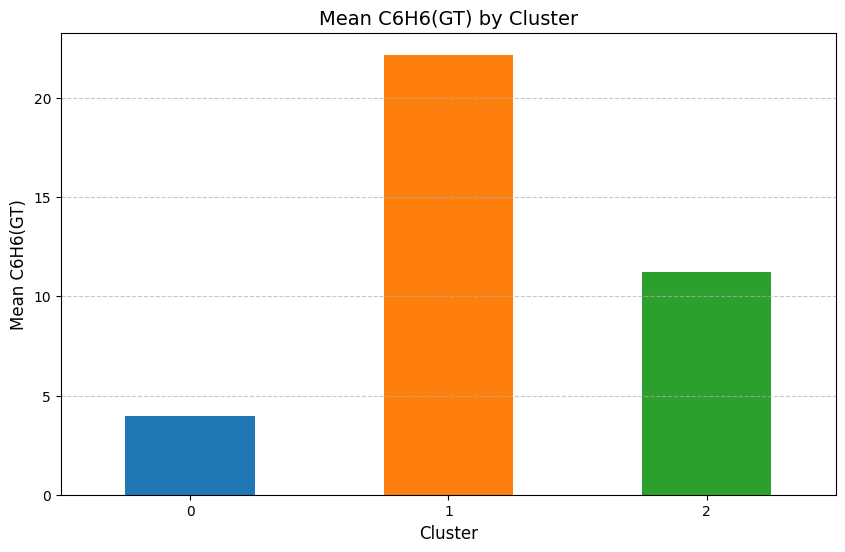

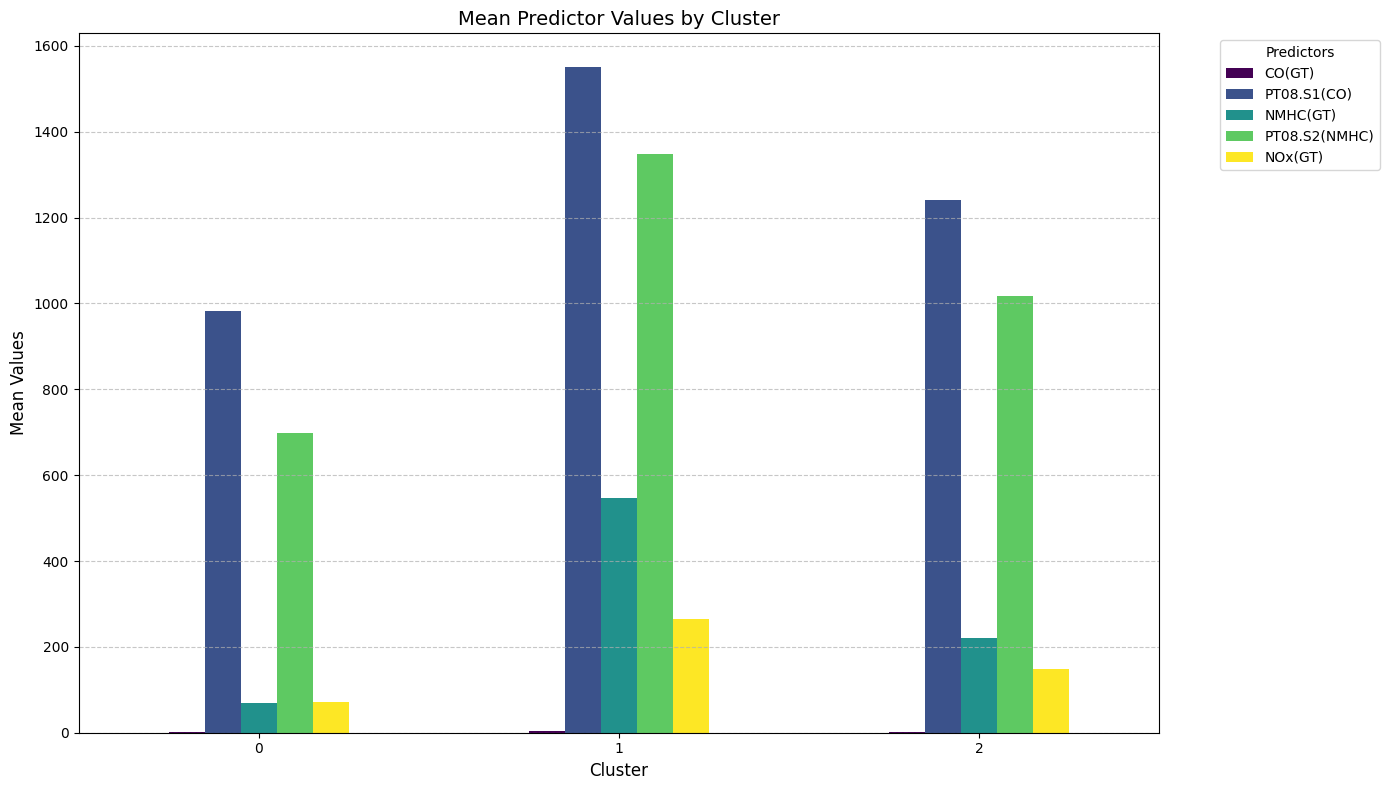

In [31]:
# Compute the mean values for each cluster
cluster_means = data.groupby("cluster")[predictor_columns + ["C6H6(GT)"]].mean()

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
cluster_means["C6H6(GT)"].plot(kind="bar", ax=ax, color=["#1f77b4", "#ff7f0e", "#2ca02c"])
ax.set_title("Mean C6H6(GT) by Cluster", fontsize=14)
ax.set_xlabel("Cluster", fontsize=12)
ax.set_ylabel("Mean C6H6(GT)", fontsize=12)
ax.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=0)
plt.show()

# Visualize a subset of predictors by cluster
fig, ax = plt.subplots(figsize=(14, 8))
cluster_means[predictor_columns[:5]].plot(kind="bar", ax=ax, colormap="viridis")
ax.set_title("Mean Predictor Values by Cluster", fontsize=14)
ax.set_xlabel("Cluster", fontsize=12)
ax.set_ylabel("Mean Values", fontsize=12)
ax.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=0)
plt.legend(title="Predictors", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

Hierarchical Modelling

In [ ]:
# Prepare data for hierarchical modeling
group_idx = data["cluster"].values  # Use clusters as the grouping variable
n_groups = len(np.unique(group_idx))  # Number of clusters/groups
X = data[predictor_columns].values  # Predictors
y = data["C6H6(GT)"].values  # Target variable

# Ensure the target variable is strictly positive
if (y <= 0).any():
    y += 0.001

# Define the hierarchical Bayesian model
with pm.Model() as hierarchical_model:
    # Hyperpriors for group-level parameters
    mu_beta = pm.Normal("mu_beta", mu=0, sigma=10, shape=len(predictor_columns))  # Population-level mean for coefficients
    sigma_beta = pm.HalfCauchy("sigma_beta", beta=2, shape=len(predictor_columns))  # Population-level variance

    mu_intercept = pm.Normal("mu_intercept", mu=0, sigma=10)  # Population-level mean for intercept
    sigma_intercept = pm.HalfCauchy("sigma_intercept", beta=2)  # Population-level variance

    # Group-level parameters
    intercept = pm.Normal("intercept", mu=mu_intercept, sigma=sigma_intercept, shape=n_groups)
    beta = pm.Normal("beta", mu=mu_beta, sigma=sigma_beta, shape=(n_groups, len(predictor_columns)))

    # Linear predictor for each group
    mu = pm.math.exp(intercept[group_idx] + pm.math.sum(beta[group_idx] * X, axis=1))

    # Shape parameter for Gamma likelihood
    alpha = pm.HalfCauchy("alpha", beta=2)

    # Likelihood
    target = pm.Gamma("target", alpha=alpha, beta=alpha / mu, observed=y)

    # Sample the posterior
    hierarchical_trace = pm.sample(1000, tune=500, init="adapt_diag", return_inferencedata=True)

    # Posterior predictive checks
    hierarchical_posterior_predictive = pm.sample_posterior_predictive(hierarchical_trace, model=hierarchical_model)

Linear Model (Bayesian)

Linear Model Prior Check

In [33]:
# Define predictors and target
predictor_columns = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 
                    'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
X = scaled_data[predictor_columns].values  # Predictors

# Bayesian Linear Regression - Prior Model
with pm.Model() as linear_prior_model:
    # Priors for coefficients and intercept
    beta = pm.Normal("beta", mu=0, sigma=10, shape=X.shape[1])  # Coefficients for predictors
    intercept = pm.Normal("intercept", mu=0, sigma=10)  # Intercept
    sigma = pm.HalfCauchy("sigma", beta=2)  # Noise standard deviation

    # Linear model
    mu = pm.math.dot(X, beta) + intercept  # Linear predictor

    # Likelihood (without observed data for prior predictive checks)
    target = pm.Normal("target", mu=mu, sigma=sigma)

    # Sample from the prior predictive distribution
    linear_prior_model = pm.sample_prior_predictive()

Sampling: [beta, intercept, sigma, target]


In [34]:
linear_prior_model

Inference data with groups:
	> prior

In [35]:
linear_prior_model_shape = linear_prior_model["prior"]["beta"].shape
linear_prior_model_shape

(1, 500, 12)

In [36]:
prior_linear_beta_values = prior_predictive["prior"]["beta"].values.reshape(linear_prior_model_shape[1], linear_prior_model_shape[2])
prior_linear_beta_values.shape

(500, 12)

In [45]:
prior_linear_intercept = prior_predictive["prior"]["intercept"].values.flatten()
type(prior_linear_intercept)

numpy.ndarray

In [39]:
prior_lienar_sigma = prior_predictive["prior"]["sigma"].values.flatten()
type(prior_lienar_sigma)

numpy.ndarray

In [42]:
prior_lienar_target = prior_predictive["prior"]["target"].values.flatten()
type(prior_lienar_target)

numpy.ndarray

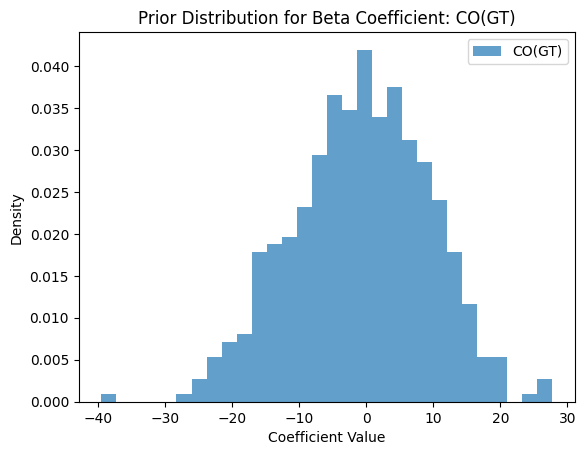

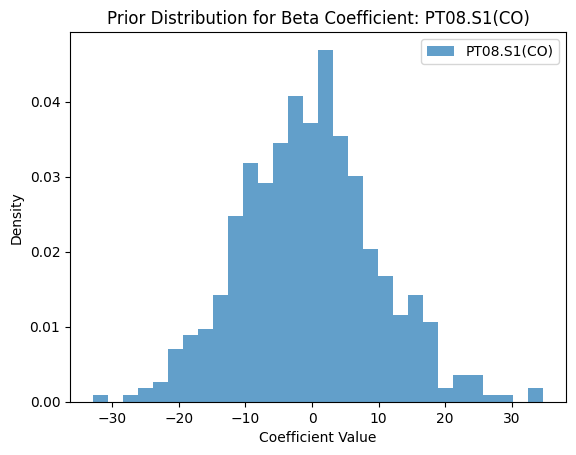

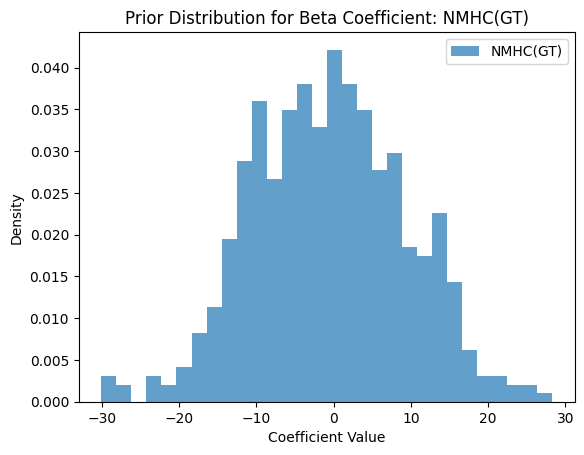

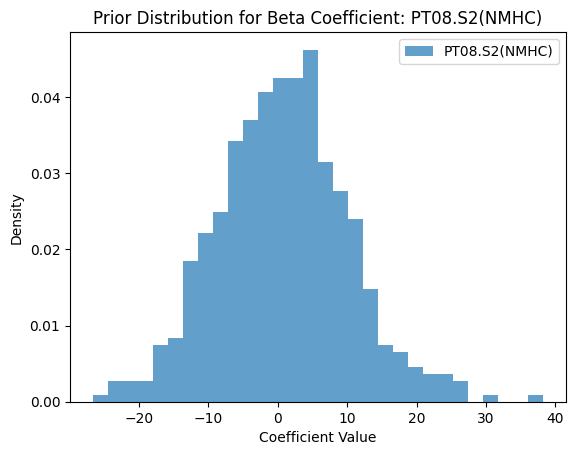

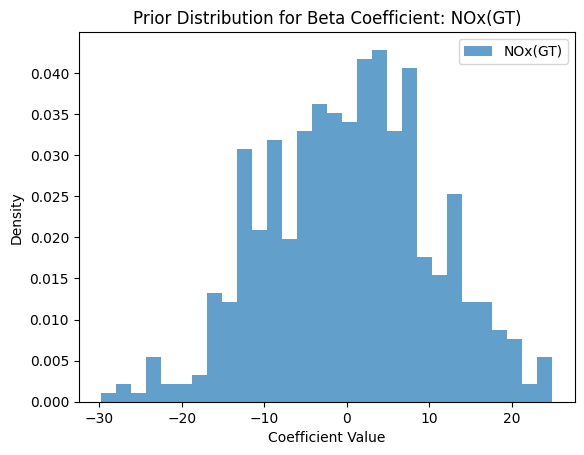

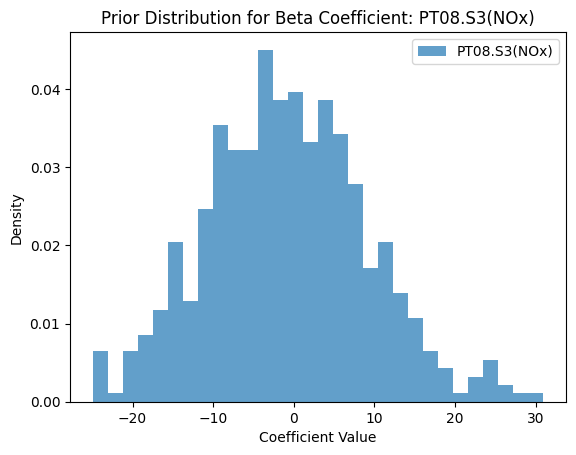

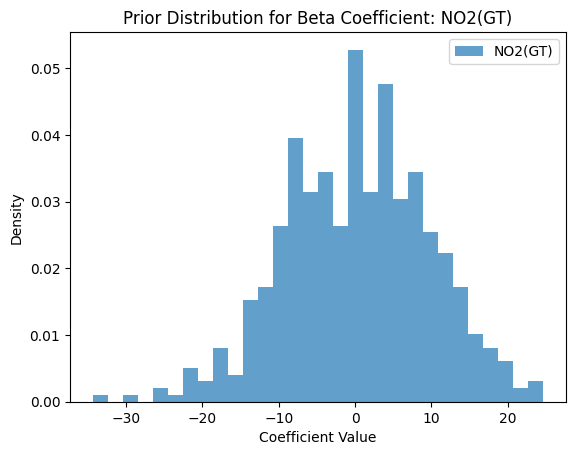

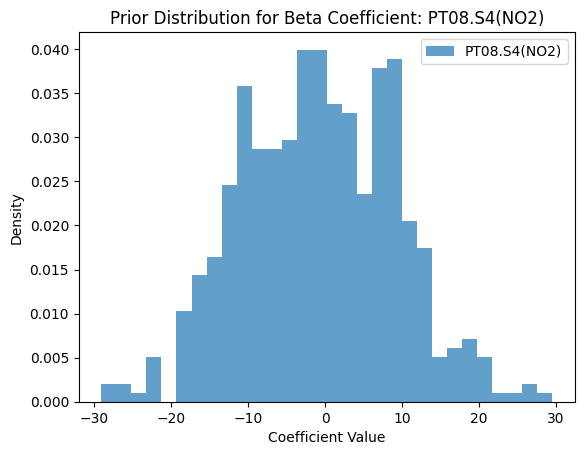

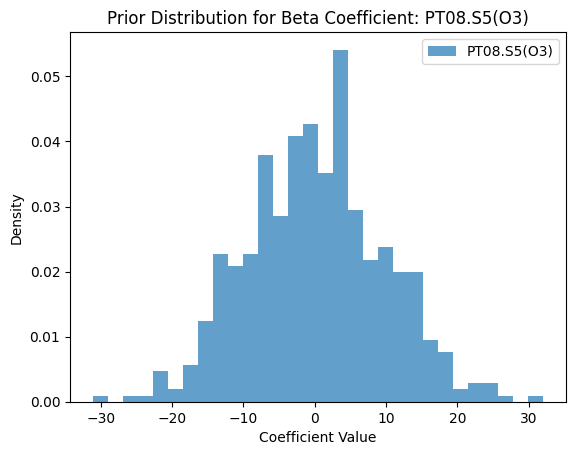

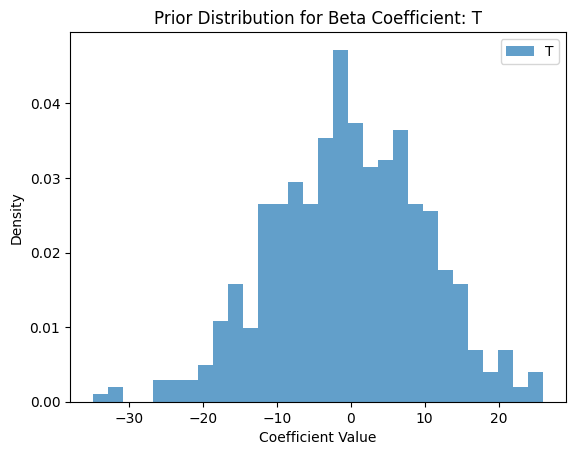

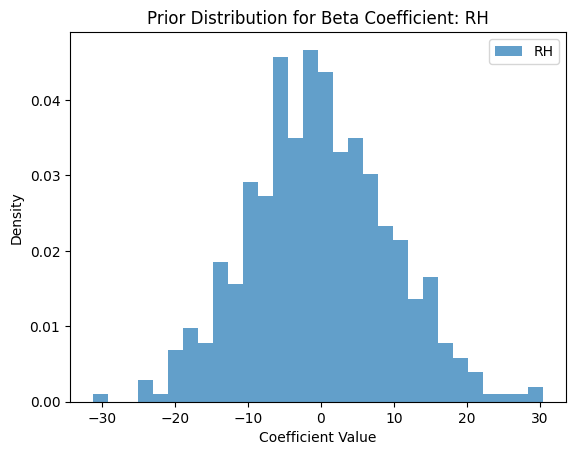

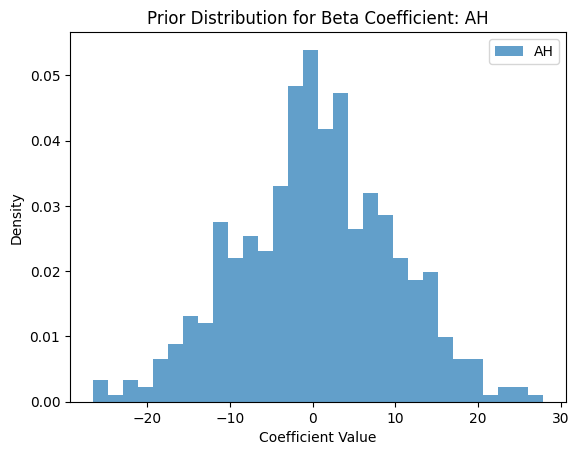

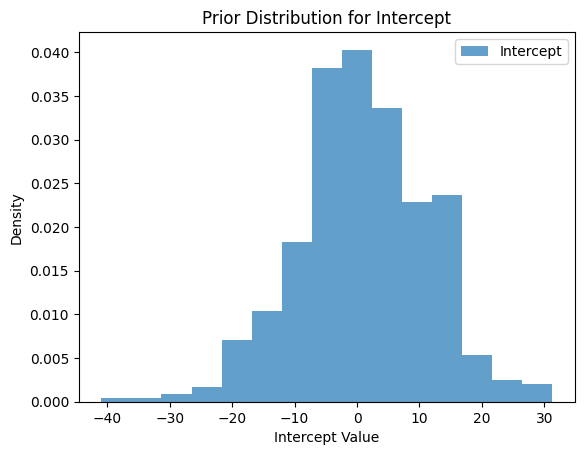

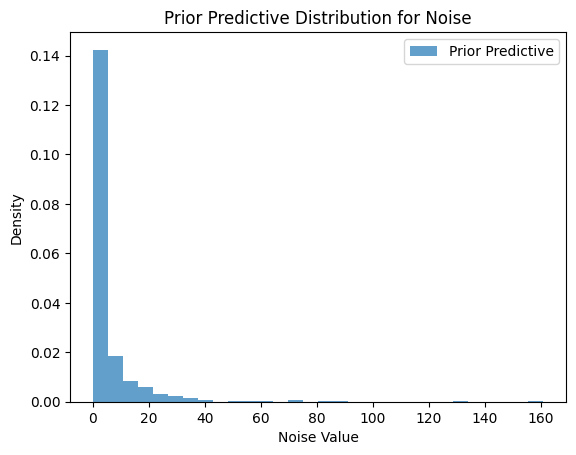

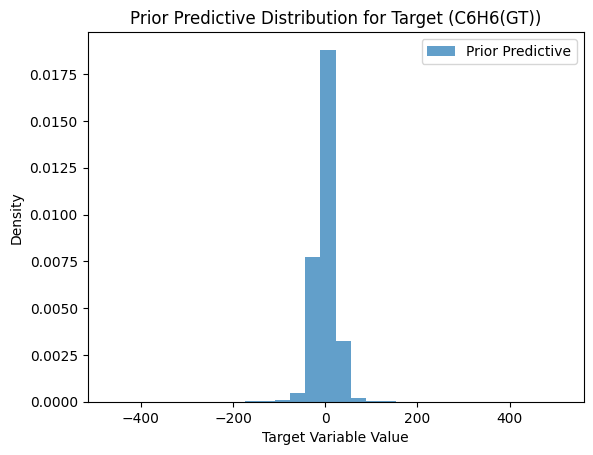

In [51]:
# Plot prior distributions for coefficients
for i, predictor in enumerate(predictor_columns):
    plt.hist(prior_linear_beta_values[:, i], bins=30, density=True, alpha=0.7, label=f"{predictor}")
    plt.title(f"Prior Distribution for Beta Coefficient: {predictor}")
    plt.xlabel("Coefficient Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

# Plot prior for intercept
plt.hist(prior_linear_intercept, bins=15, density=True, alpha=0.7, label="Intercept")
plt.title("Prior Distribution for Intercept")
plt.xlabel("Intercept Value")
plt.ylabel("Density")
plt.legend()
plt.show()

# Plot prior predictive distribution of the target variable
plt.hist(prior_lienar_sigma, bins=30, density=True, alpha=0.7, label="Prior Predictive")
plt.title("Prior Predictive Distribution for Noise")
plt.xlabel("Noise Value")
plt.ylabel("Density")
plt.legend()
plt.show()

# Plot prior predictive distribution of the target variable
plt.hist(prior_lienar_target, bins=30, density=True, alpha=0.7, label="Prior Predictive")
plt.title("Prior Predictive Distribution for Target (C6H6(GT))")
plt.xlabel("Target Variable Value")
plt.ylabel("Density")
plt.legend()
plt.show()

Linear Model (Bayesian): Posterior Check

In [54]:
# Define predictors and target
predictor_columns = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 
                    'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
X = scaled_data[predictor_columns].values  # Predictors
y = scaled_data["C6H6(GT)"].values  # Target variable

# Ensure the target is strictly positive
if (y <= 0).any():
    y += 0.001

# Bayesian Linear Regression
with pm.Model() as linear_model:
    # Priors for coefficients and intercept
    beta = pm.Normal("beta", mu=0, sigma=10, shape=X.shape[1])  # Coefficients for predictors
    intercept = pm.Normal("intercept", mu=0, sigma=10)  # Intercept
    sigma = pm.HalfCauchy("sigma", beta=2)  # Noise standard deviation

    # Linear model
    mu = pm.math.dot(X, beta) + intercept  # Linear predictor

    # Likelihood
    target = pm.Normal("target", mu=mu, sigma=sigma, observed=y)

    # Sampling
    linear_trace = pm.sample(500, tune=500, return_inferencedata=True)

    # Posterior predictive checks
    linear_posterior_predictive = pm.sample_posterior_predictive(linear_trace, model=linear_model)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [beta, intercept, sigma]


Output()

Sampling 3 chains for 500 tune and 500 draw iterations (1_500 + 1_500 draws total) took 37 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [target]


Output()

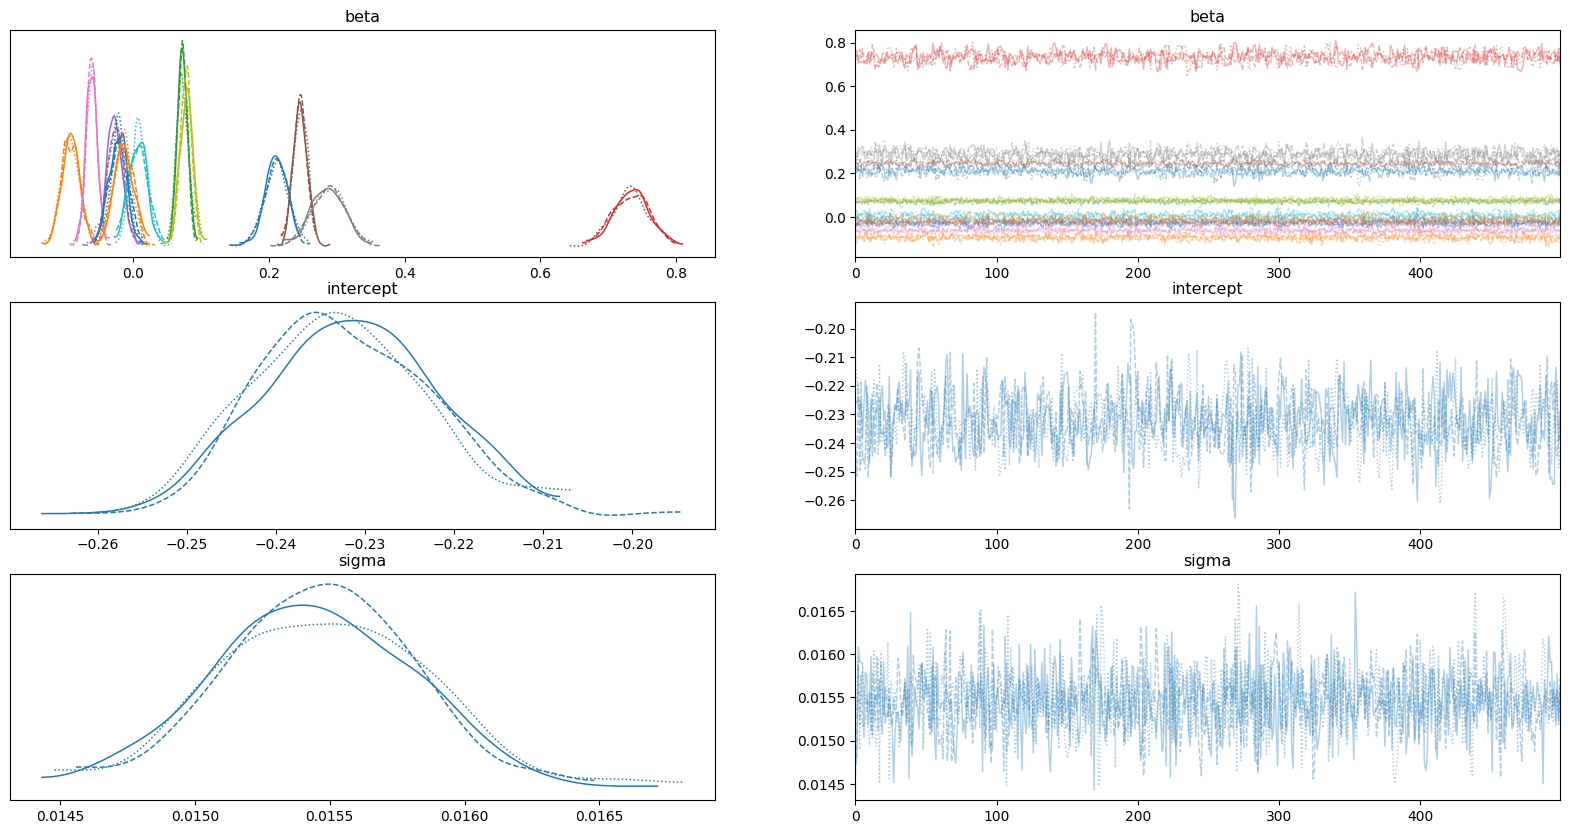

In [55]:
az.plot_trace(linear_trace, figsize=(20, 10), compact=True)
plt.show()

In [57]:
linear_posterior_predictive

Inference data with groups:
	> posterior_predictive
	> observed_data

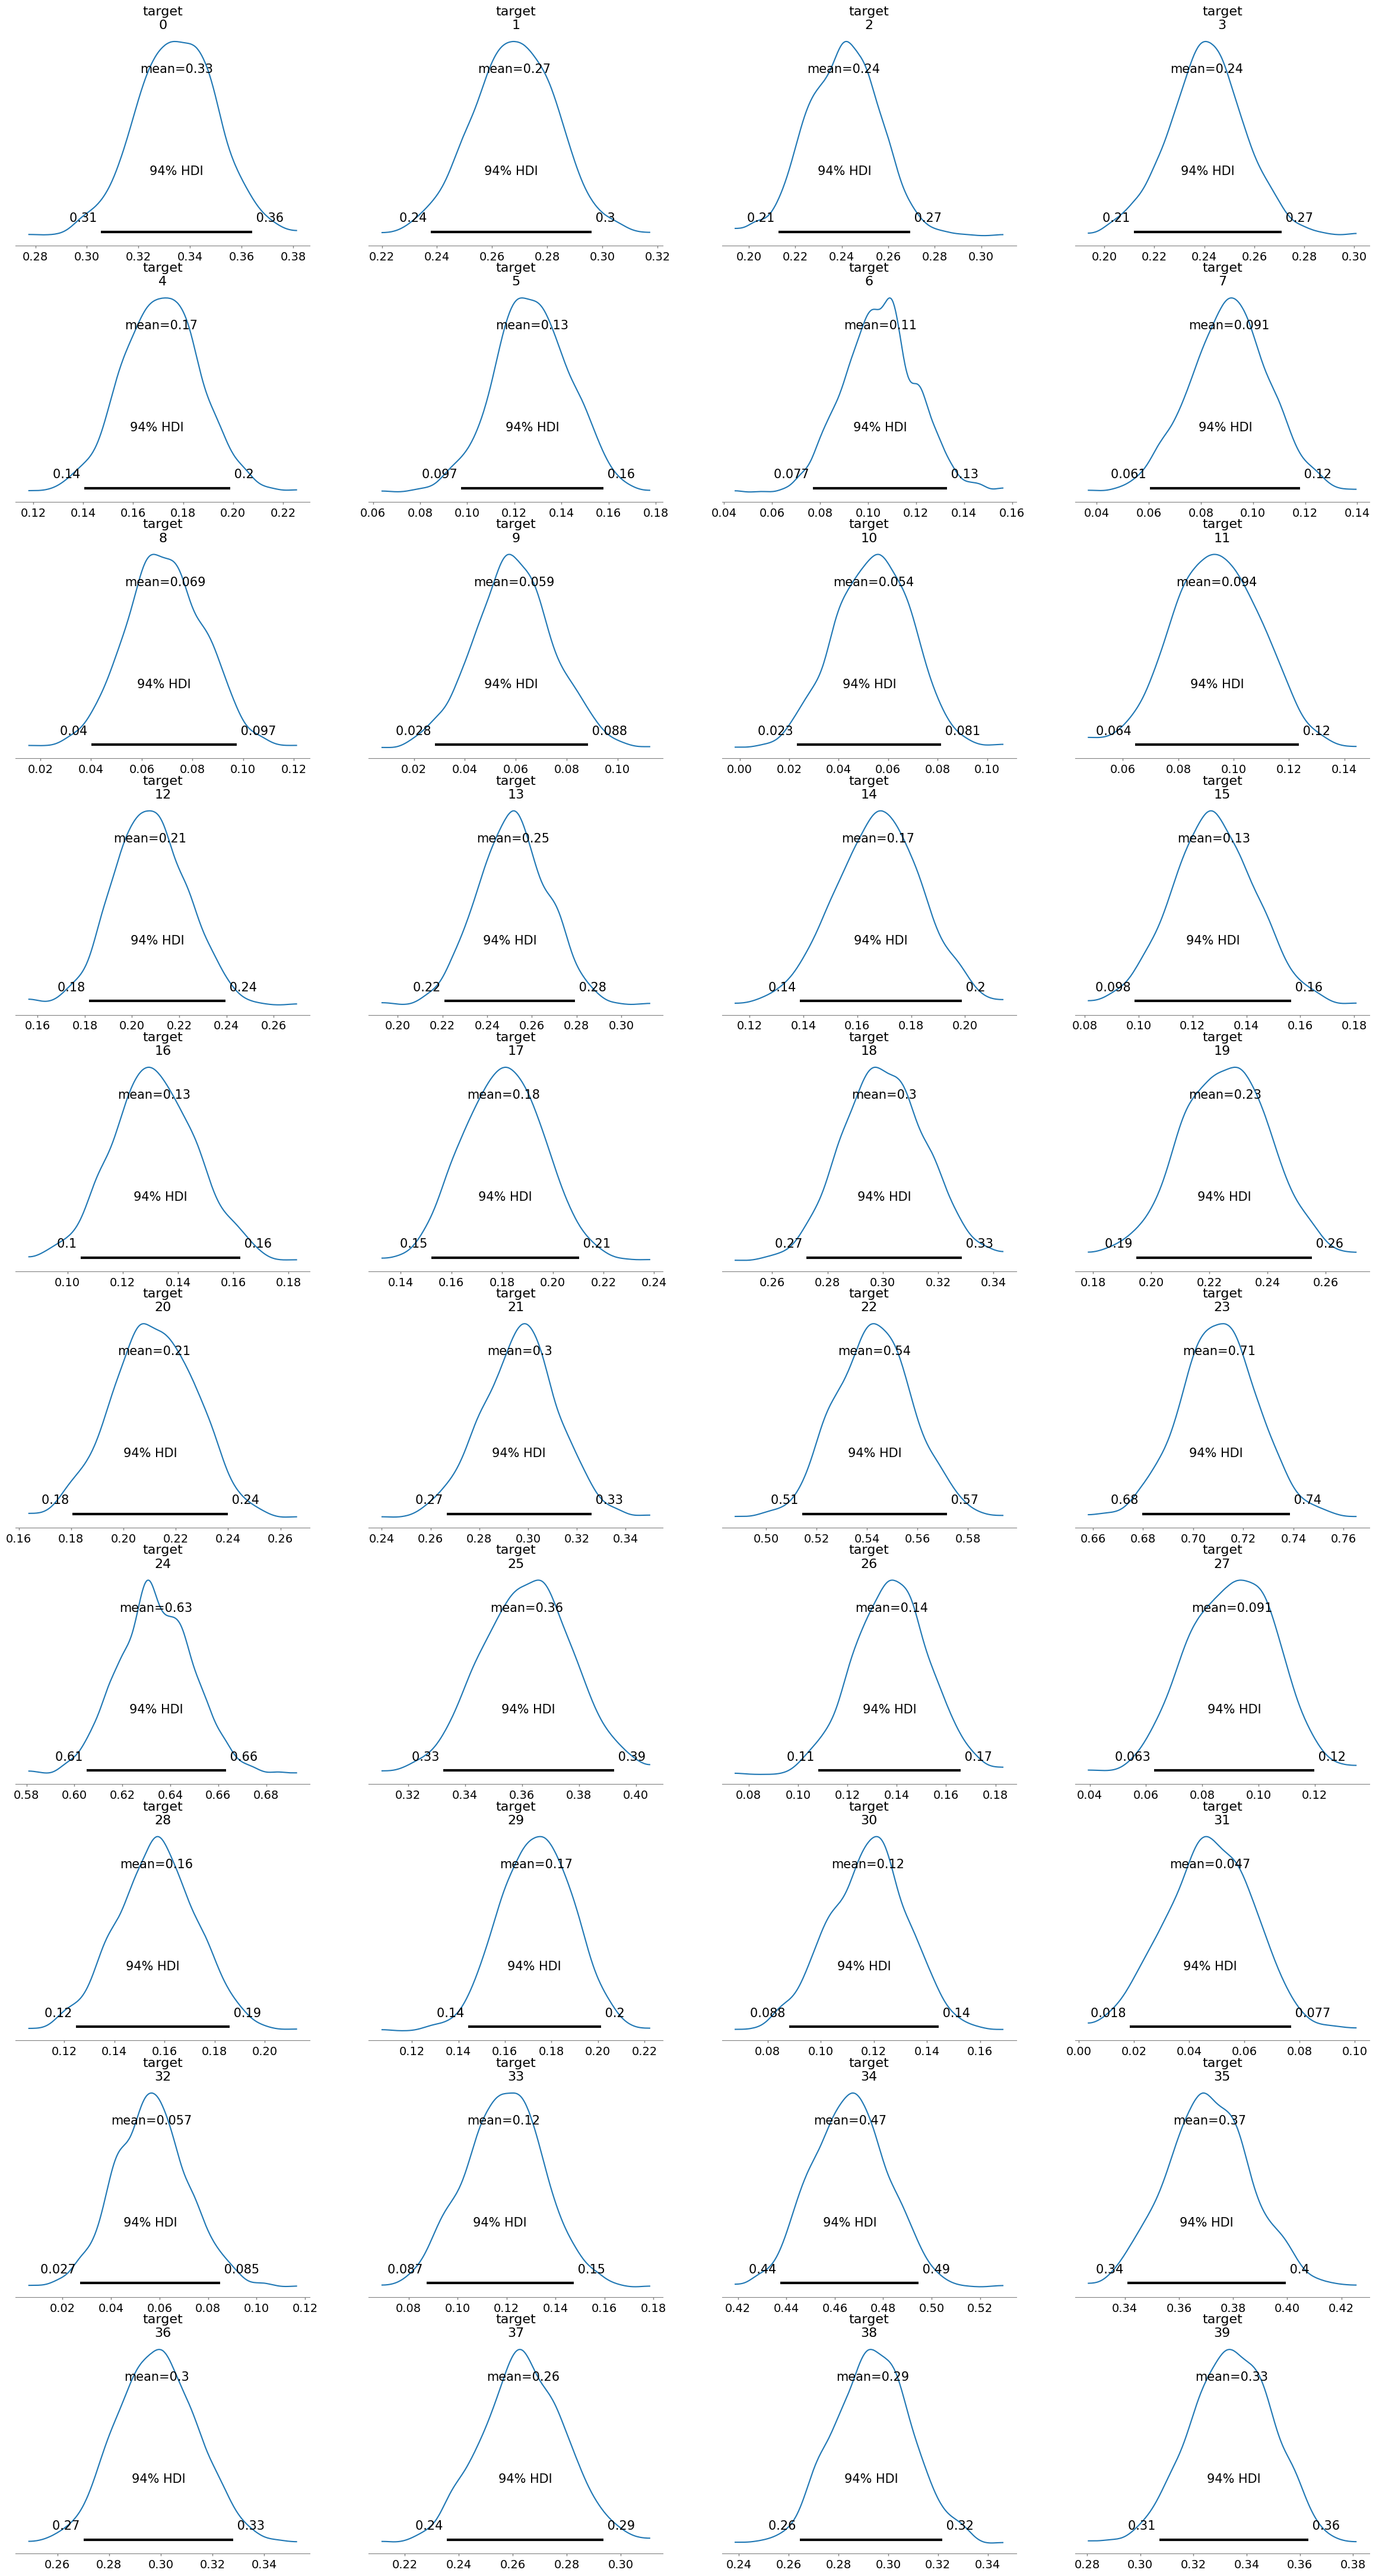

In [58]:
az.plot_posterior(linear_posterior_predictive.posterior_predictive)
# plt.savefig("posterior_beta_intercept_alpha.png")
plt.show()

In [ ]:
# Extract posterior samples for beta
gamma_beta_posterior = idata.posterior["beta"]
print(gamma_beta_posterior)

In [73]:
linear_posterior_predictive["posterior_predictive"]["target"].mean(axis = 0)

<xarray.DataArray 'target' (draw: 500, target_dim_2: 827)> Size: 3MB
array([[0.34922419, 0.27269131, 0.22690034, ..., 0.3710568 , 0.35019952,
        0.42524362],
       [0.34334052, 0.27237361, 0.21531091, ..., 0.37391889, 0.36398585,
        0.41896694],
       [0.34158577, 0.2620082 , 0.23586292, ..., 0.38677454, 0.35640332,
        0.39387956],
       ...,
       [0.31851007, 0.27512082, 0.24582375, ..., 0.37034822, 0.35456731,
        0.41684515],
       [0.32702703, 0.27761407, 0.24093381, ..., 0.36010631, 0.35881343,
        0.40028969],
       [0.34708153, 0.26318672, 0.25015415, ..., 0.3764477 , 0.3596343 ,
        0.3886337 ]])
Coordinates:
  * draw          (draw) int32 2kB 0 1 2 3 4 5 6 ... 493 494 495 496 497 498 499
  * target_dim_2  (target_dim_2) int32 3kB 0 1 2 3 4 5 ... 822 823 824 825 826

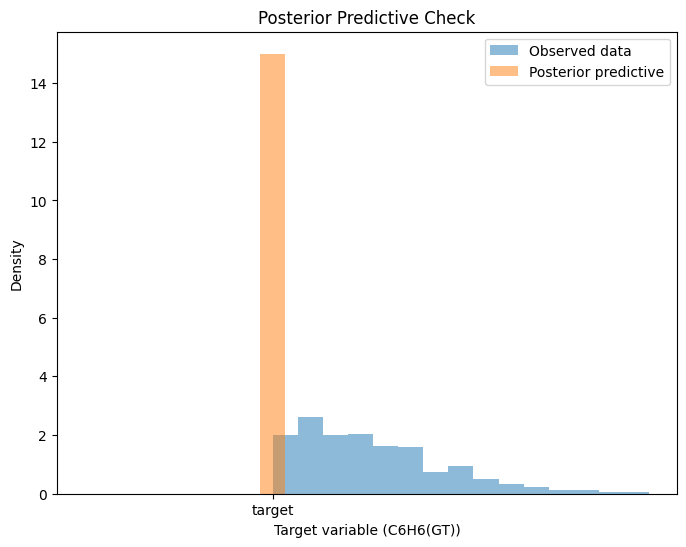

In [88]:
# Posterior predictive check
_, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.hist(y, bins=15, density=True, alpha=0.5, label="Observed data")
ax.hist(linear_posterior_predictive["posterior_predictive"], bins=15, density=True, alpha=0.5, label="Posterior predictive")
# sns.kdeplot(linear_posterior_predictive["posterior_predictive"], fill=True, alpha=0.5, label="Posterior predictive")
ax.set_xlabel("Target variable (C6H6(GT))")
ax.set_ylabel("Density")
ax.legend()
plt.title("Posterior Predictive Check")
plt.show()

In [35]:
posterior_samples = linear_posterior_predictive["posterior_predictive"]["target"].mean(dim="draw").values

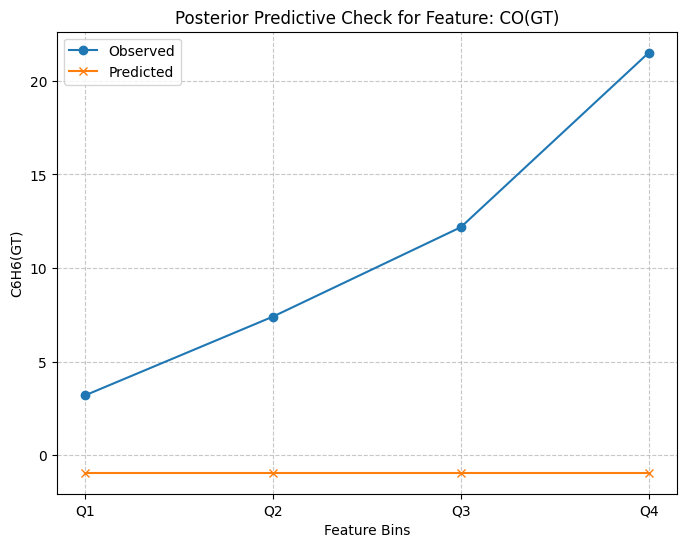

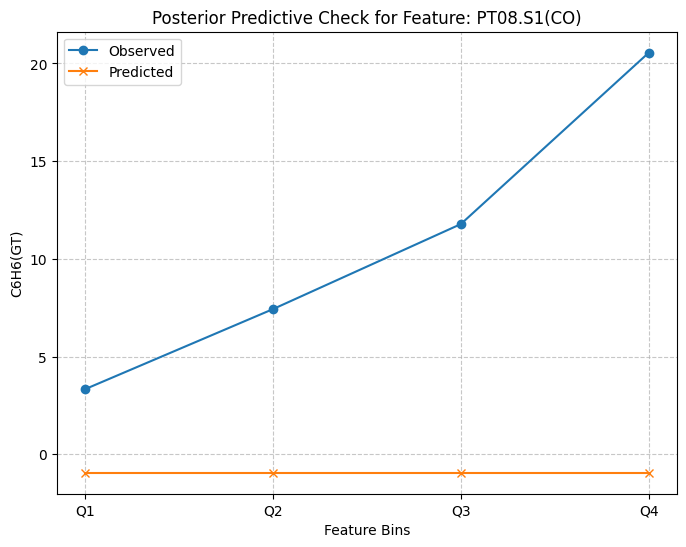

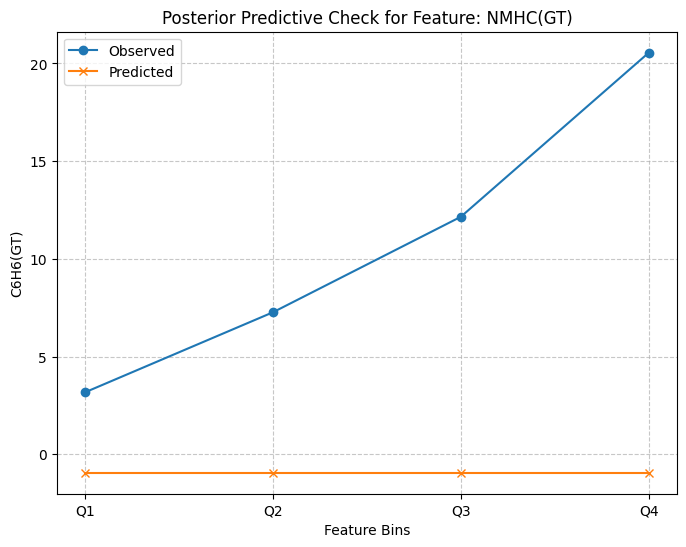

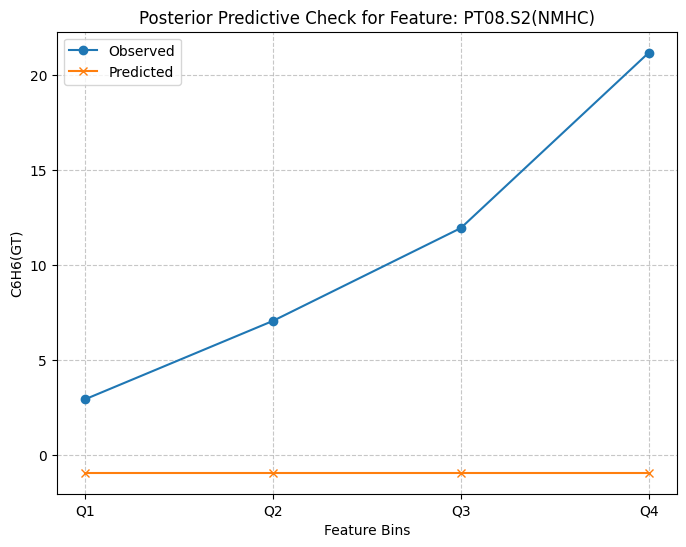

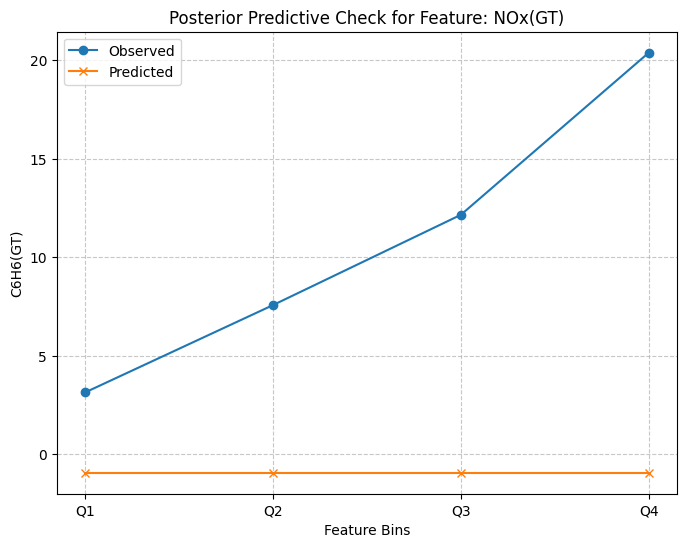

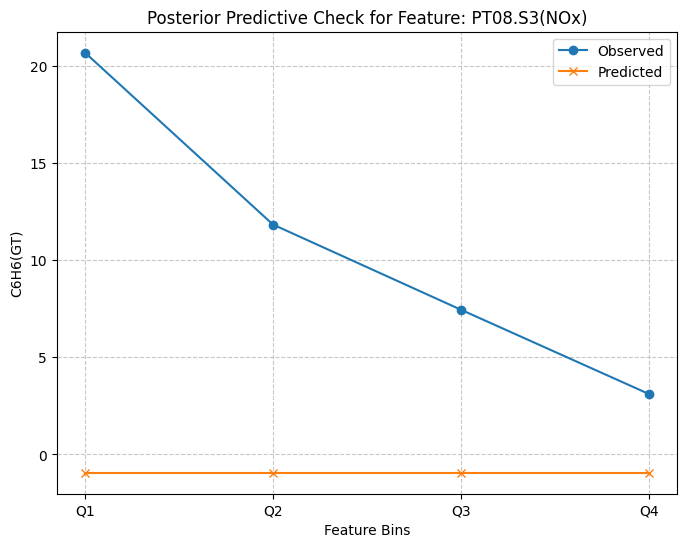

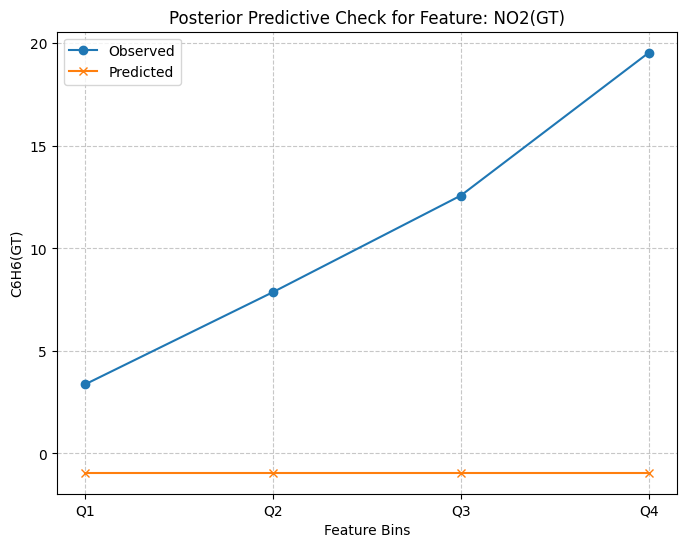

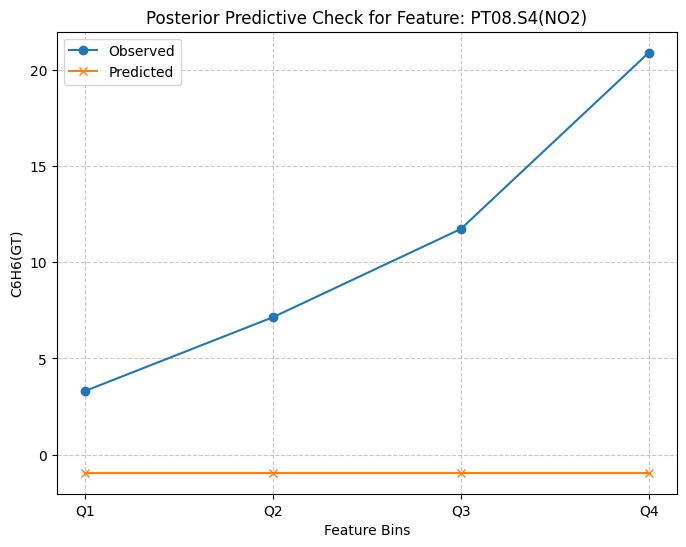

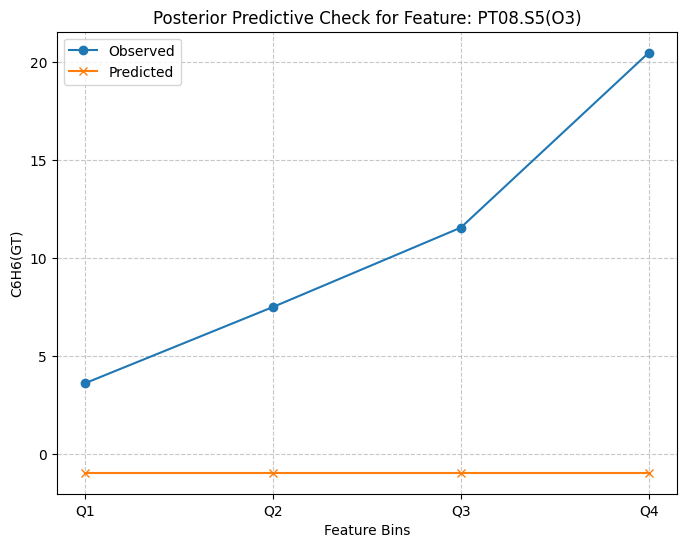

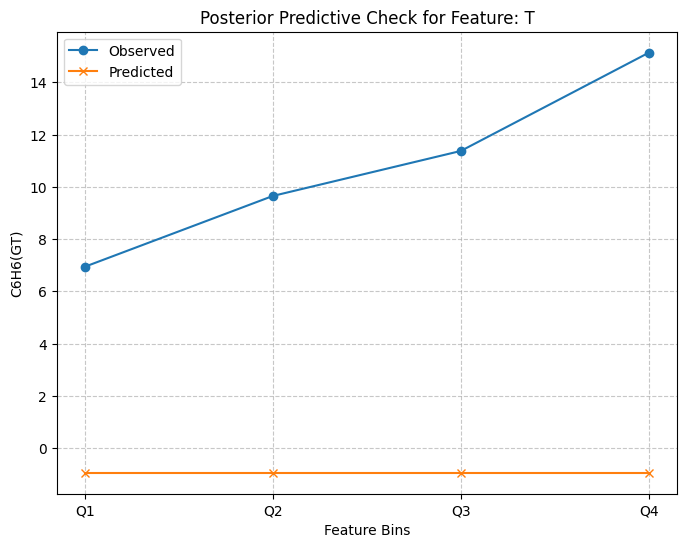

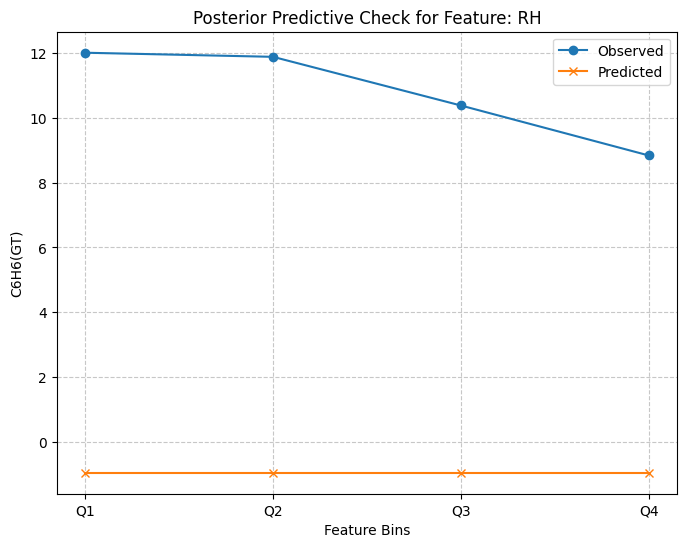

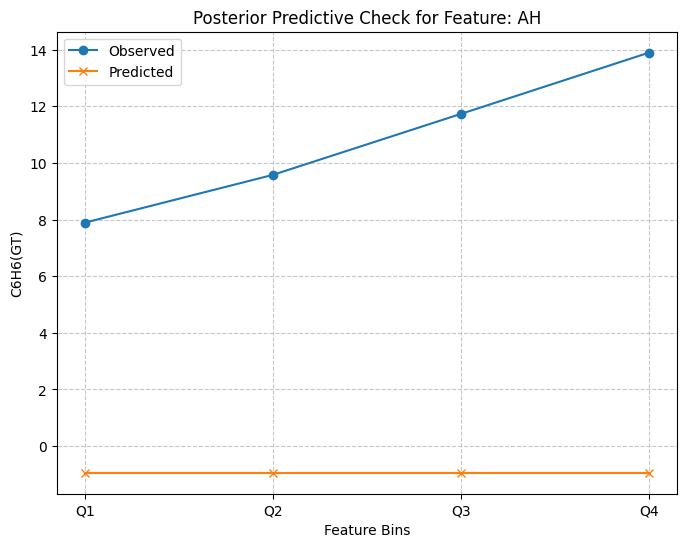

In [90]:
# Compute posterior predictive means for each observation
linear_posterior_means = posterior_samples.mean(axis=0)  # Average over the draws

# Convert predictors to a DataFrame
X_scaled_df = pd.DataFrame(X, columns=predictor_columns)

# Iterate through each predictor
for feature in predictor_columns:
    # Bin the feature into quantiles for grouping
    bins = np.quantile(X_scaled_df[feature], [0, 0.25, 0.5, 0.75, 1.0])  # Quartiles
    bin_labels = ['Q1', 'Q2', 'Q3', 'Q4']
    X_scaled_df[f"{feature}_bin"] = pd.cut(X_scaled_df[feature], bins=bins, labels=bin_labels, include_lowest=True)

    # Compute observed and predicted means for each bin
    observed_means = data.groupby(X_scaled_df[f"{feature}_bin"])["C6H6(GT)"].mean()
    predicted_means = pd.DataFrame({
        f"{feature}_bin": X_scaled_df[f"{feature}_bin"],
        "predicted": linear_posterior_means
    }).groupby(f"{feature}_bin")["predicted"].mean()

    # Plot observed vs. predicted for the feature
    plt.figure(figsize=(8, 6))
    plt.plot(bin_labels, observed_means, label="Observed", marker="o")
    plt.plot(bin_labels, predicted_means, label="Predicted", marker="x")
    plt.title(f"Posterior Predictive Check for Feature: {feature}")
    plt.xlabel("Feature Bins")
    plt.ylabel("C6H6(GT)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()


In [92]:
linear_prior_model

Inference data with groups:
	> prior

In [95]:
linear_posterior_predictive["posterior_predictive"]["target"]

<xarray.DataArray 'target' (chain: 3, draw: 500, target_dim_2: 827)> Size: 10MB
array([[[0.36339605, 0.27170634, 0.21373236, ..., 0.3994708 ,
         0.34766146, 0.41478298],
        [0.36854541, 0.27582426, 0.22025739, ..., 0.34121471,
         0.36602405, 0.42283904],
        [0.34279312, 0.26582616, 0.24221337, ..., 0.38637053,
         0.3374654 , 0.39490931],
        ...,
        [0.33811207, 0.28318826, 0.23583739, ..., 0.35586336,
         0.35747996, 0.42716325],
        [0.31670141, 0.26980499, 0.23963043, ..., 0.36813949,
         0.37379001, 0.39221473],
        [0.35669688, 0.26340493, 0.2510079 , ..., 0.41110047,
         0.34895869, 0.38390047]],

       [[0.36123218, 0.27740202, 0.24701721, ..., 0.35665794,
         0.34254042, 0.42412181],
        [0.32095369, 0.27527722, 0.20499571, ..., 0.38345933,
         0.36129717, 0.40430679],
        [0.34036702, 0.27320555, 0.2500719 , ..., 0.37207558,
         0.36999617, 0.38573607],
...
        [0.31211302, 0.29515622, 0.24588541, ..., 0.38554259,
         0.35393762, 0.40877057],
        [0.32563678, 0.28208299, 0.2446263 , ..., 0.36474278,
         0.35492548, 0.41340784],
        [0.33442139, 0.27771765, 0.26069075, ..., 0.35287049,
         0.35384917, 0.39703993]],

       [[0.32304433, 0.26896555, 0.21995144, ..., 0.35704165,
         0.36039667, 0.43682606],
        [0.34052245, 0.26601934, 0.22067962, ..., 0.39708262,
         0.36463634, 0.42975498],
        [0.34159718, 0.24699288, 0.2153035 , ..., 0.40187749,
         0.3617484 , 0.40099331],
        ...,
        [0.30530511, 0.247018  , 0.25574844, ..., 0.36963872,
         0.35228435, 0.41460164],
        [0.3387429 , 0.28095424, 0.23854471, ..., 0.34743666,
         0.3477248 , 0.3952465 ],
        [0.35012633, 0.24843757, 0.23876379, ..., 0.36537214,
         0.37609504, 0.38496072]]])
Coordinates:
  * chain         (chain) int32 12B 0 1 2
  * draw          (draw) int32 2kB 0 1 2 3 4 5 6 ... 493 494 495 496 497 498 499
  * target_dim_2  (target_dim_2) int32 3kB 0 1 2 3 4 5 ... 822 823 824 825 826

In [ ]:
for i, predictor_name in enumerate(predictor_variables):
    # for posterior_gamma_beta in posterior_gamma_beta_values:
    # Extract prior and posterior for each predictor
    prior_samples = prior_linear_beta_values[:, i]
    posterior_samples = linear_posterior_predictive["beta"].sel(beta_dim_0=i).values.flatten()
    # posterior_samples = idata.posterior["beta"].values.reshape((-1, idata.posterior["beta"].values.shape[1], idata.posterior["beta"].values.shape[2]))
    #idata.posterior["beta"].sel(beta_dim_0=i)#.values.flatten() #posterior_gamma_beta_values#
    # gamma_beta_posterior.sel(beta_dim_0=i).values.flatten()

    # Plot prior vs. posterior
    plt.figure(figsize=(8, 6))#(8, 6)
    # plt.hist(prior_samples, bins=100, density=True, alpha=0.5, label=f"Prior for {predictor_name}")
    # plt.hist(posterior_samples, bins=100, density=True, alpha=0.5, label=f"Posterior for {predictor_name}")
    sns.kdeplot(prior_samples, fill=True, alpha=0.2, label=f"Prior for {predictor_name}")
    sns.kdeplot(posterior_samples, fill=True, alpha=0.2, label=f"Posterior for {predictor_name}")
    plt.title(f"Prior vs. Posterior for {predictor_name}")
    plt.xlabel("Coefficient Value")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()


Model Comparison

In [135]:
df_comp_loo_stduent_t_gamma = az.compare({"Student-t": trace_student_t, "Gamma": idata})
df_comp_loo_stduent_t_gamma

rank     elpd_loo      p_loo    elpd_diff    weight         se  \
Gamma         0  1698.434615  26.617834     0.000000  0.999512  64.111420   
Student-t     1  -780.367884   0.194803  2478.802498  0.000488   0.224689   

                 dse  warning scale  
Gamma       0.000000     True   log  
Student-t  64.054331    False   log

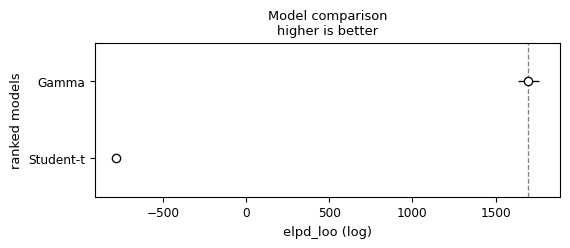

In [136]:
az.plot_compare(df_comp_loo_stduent_t_gamma, insample_dev=False);